In [1]:
import pandas as pd
import numpy as np

import itertools
import math

# from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA

from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split, GridSearchCV
from surprise import accuracy

import warnings
warnings.filterwarnings("ignore")

In [2]:
test_data = pd.read_csv('last_orders_subset.csv')
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5487 entries, 0 to 5486
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Order          5487 non-null   int64 
 1   SKU            5487 non-null   int64 
 2   Member         5487 non-null   object
 3   Delivery Date  5487 non-null   object
 4   Name           5487 non-null   object
dtypes: int64(2), object(3)
memory usage: 214.5+ KB


In [3]:
df = pd.read_csv('all_except_last_orders.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28984 entries, 0 to 28983
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Order          28984 non-null  int64 
 1   SKU            28984 non-null  int64 
 2   Member         28984 non-null  object
 3   Delivery Date  28984 non-null  object
 4   Name           28984 non-null  object
dtypes: int64(2), object(3)
memory usage: 1.1+ MB


In [4]:
df['Delivery Date'] = pd.to_datetime(df['Delivery Date'], dayfirst = True)

# Sample Submission

In [5]:
order_list = list(set(test_data["Order"]))
len(order_list)

638

In [6]:
df_list = []
for order in order_list:
    top5 = test_data[test_data["Order"] == order].head()
    df_list.append(top5)
sample_submission = pd.concat(df_list, ignore_index = True)

In [7]:
sample_submission.head()

,Order,SKU,Member,Delivery Date,Name
0,7817216,15669994,SWNHNRN,03/09/12,Other Dals
1,7817216,15668465,SWNHNRN,03/09/12,Root Vegetables
2,7817216,15668687,SWNHNRN,03/09/12,Root Vegetables
3,7817216,15668468,SWNHNRN,03/09/12,Beans
4,7817216,15668520,SWNHNRN,03/09/12,Bread


In [8]:
sample_submission = sample_submission[["Order", "SKU", "Member"]].reset_index().rename(columns = {"index": "ID"})
sample_submission["ID"] = sample_submission["ID"].apply(lambda x: x+1)
sample_submission.head()

,ID,Order,SKU,Member
0,1,7817216,15669994,SWNHNRN
1,2,7817216,15668465,SWNHNRN
2,3,7817216,15668687,SWNHNRN
3,4,7817216,15668468,SWNHNRN
4,5,7817216,15668520,SWNHNRN


In [9]:
# sample_submission.to_csv("sample_submission.csv")

# Baseline Recommendation

Based on the frequency of the items in the past orders for that particular user

In [10]:
sku_freq_df = df[["Member", "SKU"]].groupby(["Member", "SKU"]) \
                .size() \
                .reset_index(name='frequency') \
                .sort_values(by = ["Member", "frequency"], ascending = [True, False])

sku_freq_df.head()

,Member,SKU,frequency
2,SSCEHNS,7580823,7
8,SSCEHNS,15668377,7
34,SSCEHNS,15669865,7
20,SSCEHNS,15669772,6
40,SSCEHNS,15669970,6


In [11]:
test_data.head()

,Order,SKU,Member,Delivery Date,Name
0,7409204,15669778,SWLCNOE,05/09/13,Other Dals
1,8076206,15669977,SWOEZES,01/04/14,Almonds
2,7560723,7593949,SSWWRHW,30/06/13,Cream Biscuits
3,8362837,15669764,SWLSCOZ,06/11/13,Besan
4,8202458,15670196,SSRCRSO,03/02/14,Organic F&V


In [12]:
order_member_sku_df = test_data[["Order", "Member", "SKU"]]
order_member_sku_df.head()

,Order,Member,SKU
0,7409204,SWLCNOE,15669778
1,8076206,SWOEZES,15669977
2,7560723,SSWWRHW,7593949
3,8362837,SWLSCOZ,15669764
4,8202458,SSRCRSO,15670196


In [13]:
sku_freq_with_curr_order = pd.merge(sku_freq_df, order_member_sku_df, how = "left", on = ["Member", "SKU"])
sku_freq_with_curr_order.head()

,Member,SKU,frequency,Order
0,SSCEHNS,7580823,7,NaN
1,SSCEHNS,15668377,7,NaN
2,SSCEHNS,15669865,7,8069966.0
3,SSCEHNS,15669772,6,NaN
4,SSCEHNS,15669970,6,8069966.0


In [14]:
SSCEHNS_past = sku_freq_df[sku_freq_df["Member"] == "SWOEZES"]

In [15]:
SSCEHNS_order = order_member_sku_df[(order_member_sku_df["Order"] == 8076206)]

In [16]:
recc_sku = list()
for past_sku in list(SSCEHNS_past["SKU"]):
    if past_sku in list(SSCEHNS_order["SKU"]):
        pass
    else:
        recc_sku.append(past_sku)

In [17]:
recc_sku[:5]

[15669869, 15669878, 15669866, 7587667, 7642810]

In [18]:
sku_freq_with_curr_order[(sku_freq_with_curr_order["Order"].isna()) & (sku_freq_with_curr_order["Member"] == "SWLCNOE")].head()

,Member,SKU,frequency,Order
10642,SWLCNOE,15668465,4,NaN
10644,SWLCNOE,15668459,3,NaN
10645,SWLCNOE,15668460,3,NaN
10646,SWLCNOE,15668467,3,NaN
10647,SWLCNOE,15668494,3,NaN


In [19]:
sku_freq_with_curr_order[sku_freq_with_curr_order["Member"] == "SWLCNOE"].head()

,Member,SKU,frequency,Order
10640,SWLCNOE,15668478,8,7409204.0
10641,SWLCNOE,15668379,6,7409204.0
10642,SWLCNOE,15668465,4,NaN
10643,SWLCNOE,15668457,3,7409204.0
10644,SWLCNOE,15668459,3,NaN
10645,SWLCNOE,15668460,3,NaN
10646,SWLCNOE,15668467,3,NaN
10647,SWLCNOE,15668494,3,NaN
10648,SWLCNOE,15668594,3,NaN
10649,SWLCNOE,15668688,3,7409204.0


In [20]:
recc_df_list = list()

for _, row in test_data[["Order", "Member"]].drop_duplicates().iterrows():
    df_temp = sku_freq_with_curr_order[sku_freq_with_curr_order["Member"] == row["Member"]] \
                .fillna("1000000000") \
                .sort_values(["Order", "frequency"], ascending = [False, False]) \
                .head()
    df_temp["Order"] = row["Order"]
    recc_df_list.append(df_temp.drop("frequency", axis = 1))

recc_df = pd.concat(recc_df_list, ignore_index = True)

In [21]:
recc_df = recc_df[["Order", "SKU", "Member"]].reset_index().rename(columns = {"index": "ID"})
recc_df["ID"] = recc_df["ID"].apply(lambda x: x+1)
recc_df.head()

,ID,Order,SKU,Member
0,1,7409204,15668465,SWLCNOE
1,2,7409204,15668459,SWLCNOE
2,3,7409204,15668460,SWLCNOE
3,4,7409204,15668467,SWLCNOE
4,5,7409204,15668494,SWLCNOE


In [22]:
# recc_df.to_csv("past_frequency_based_recc.csv", index = False)

# Train Test Split

The data is split into last orders (for members who have more than 5 orders) and all but last order.
Previous orders are used to train the recommendation system and the last orders are used for testing.

## Last Order per Member

In [23]:
df.head()

,Order,SKU,Member,Delivery Date,Name
0,8358896,15668375,SSCEHNS,2013-11-02,Root Vegetables
1,8358896,15668467,SSCEHNS,2013-11-02,Beans
2,8358896,15669863,SSCEHNS,2013-11-02,Moong Dal
3,8358896,15669778,SSCEHNS,2013-11-02,Other Dals
4,8358896,15669767,SSCEHNS,2013-11-02,Urad Dal


In [24]:
member_order_count = df[["Member", "Order"]].drop_duplicates()["Member"].value_counts().reset_index()
members_with_more_than_5_orders = member_order_count[member_order_count["count"] > 5]["Member"]
len(members_with_more_than_5_orders)

166

In [25]:
last_orders = df[df["Member"].isin(members_with_more_than_5_orders)][["Member", "Order", "Delivery Date"]] \
                .drop_duplicates() \
                .sort_values(["Order", "Delivery Date"], ascending = [True, False]) \
                .drop_duplicates(subset = "Member") \
                .reset_index(drop = True)["Order"]

In [26]:
len(last_orders)

166

In [27]:
df_train = df[~df["Order"].isin(last_orders)]
df_train.head()

,Order,SKU,Member,Delivery Date,Name
0,8358896,15668375,SSCEHNS,2013-11-02,Root Vegetables
1,8358896,15668467,SSCEHNS,2013-11-02,Beans
2,8358896,15669863,SSCEHNS,2013-11-02,Moong Dal
3,8358896,15669778,SSCEHNS,2013-11-02,Other Dals
4,8358896,15669767,SSCEHNS,2013-11-02,Urad Dal


In [28]:
df_test = df[df["Order"].isin(last_orders)]
df_test.head()

,Order,SKU,Member,Delivery Date,Name
94,8101324,15668377,SSCEHNS,2014-03-15,Root Vegetables
95,8101324,15668684,SSCEHNS,2014-03-15,Beans
96,8101324,15669778,SSCEHNS,2014-03-15,Other Dals
97,8101324,15668521,SSCEHNS,2014-03-15,Bread
98,8101324,15669865,SSCEHNS,2014-03-15,Other Dals


In [29]:
# df_train.to_csv("df_train.csv", index = False)
# df_test.to_csv("df_test.csv", index = False)

## Simulating Forgotten Items

In [30]:
basket_list = list()
forgotten_list = list()

for order in df_test["Order"].unique():
    y_dummy = ['']*df_test[df_test["Order"] == order].shape[0]
    basket, forgotten, _, _ = train_test_split(df_test[df_test["Order"] == order], y_dummy, test_size = 5, random_state = 101)
    basket_list.append(basket)
    forgotten_list.append(forgotten)

test_basket_df = pd.concat(basket_list, ignore_index = True)
forgotten_items_df = pd.concat(forgotten_list, ignore_index = True)

In [31]:
test_basket_df["Order"].value_counts()

Order
7362753    26
7392553    20
7566535    19
7391877    16
7428900    16
           ..
7453262     3
7460103     3
7513528     3
7352666     3
8101324     3
Name: count, Length: 166, dtype: int64

In [32]:
forgotten_items_df["Order"].value_counts()

Order
8101324    5
7734044    5
7585543    5
7644998    5
7770723    5
          ..
7370908    5
7391877    5
7360479    5
7370657    5
7737427    5
Name: count, Length: 166, dtype: int64

In [33]:
# test_basket_df.to_csv("test_basket_df.csv", index = False)
# forgotten_items_df.to_csv("forgotten_items_df.csv", index = False)

# Recommendation Engine 1: Item Based Collaborative Filtering

## SKU Co-occurrence Matrix

In [59]:
df_train = pd.read_csv("df_train.csv")
df_train.head()

,Order,SKU,Member,Delivery Date,Name
0,8358896,15668375,SSCEHNS,2013-11-02,Root Vegetables
1,8358896,15668467,SSCEHNS,2013-11-02,Beans
2,8358896,15669863,SSCEHNS,2013-11-02,Moong Dal
3,8358896,15669778,SSCEHNS,2013-11-02,Other Dals
4,8358896,15669767,SSCEHNS,2013-11-02,Urad Dal


In [60]:
sku_list = list(df_train["SKU"].unique())
len(sku_list)

632

In [61]:
pairs = list(itertools.combinations_with_replacement(sku_list, 2))
print(len(pairs))

200028


In [62]:
%%time

s1_list = list()
s2_list = list()
cooccur_list = list()

for s1, s2 in pairs:
    s1_list.append(s1)
    s2_list.append(s2)
    
    freq = len(set(df_train[df_train["SKU"] == s1]["Order"]) \
               .intersection(set(df_train[df_train["SKU"] == s2]["Order"]))
              )
    cooccur_list.append(freq)

pairwise_cooccurrence = pd.DataFrame({"SKU1": s1_list, "SKU2": s2_list, "cooccurrence_frequency": cooccur_list})
pairwise_cooccurrence.head()

CPU times: user 25.9 s, sys: 57.6 ms, total: 26 s
Wall time: 26.2 s


,SKU1,SKU2,cooccurrence_frequency
0,15668375,15668375,108
1,15668375,15668467,33
2,15668375,15669863,13
3,15668375,15669778,11
4,15668375,15669767,4


In [63]:
%%time

co_matrix = pd.DataFrame(np.zeros((len(sku_list), len(sku_list))), index=sku_list, columns=sku_list)

for _, row in pairwise_cooccurrence.iterrows():
    co_matrix.loc[row["SKU1"], row["SKU2"]] = row["cooccurrence_frequency"]
    co_matrix.loc[row["SKU2"], row["SKU1"]] = row["cooccurrence_frequency"]

co_matrix.head()

CPU times: user 7.18 s, sys: 8.37 ms, total: 7.19 s
Wall time: 7.19 s


,15668375,15668467,15669863,15669778,15669767,15669832,15669772,15669970,15668478,15669861,...,7590868,15668382,7582051,7590866,7735524,15670172,7590864,92433757,92286348,7610713
15668375,108.0,33.0,13.0,11.0,4.0,4.0,11.0,3.0,27.0,12.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15668467,33.0,322.0,31.0,25.0,19.0,18.0,27.0,4.0,62.0,21.0,...,1.0,4.0,1.0,8.0,0.0,0.0,5.0,0.0,1.0,1.0
15669863,13.0,31.0,299.0,45.0,43.0,42.0,47.0,4.0,24.0,43.0,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
15669778,11.0,25.0,45.0,243.0,19.0,23.0,69.0,4.0,21.0,40.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
15669767,4.0,19.0,43.0,19.0,184.0,38.0,29.0,4.0,7.0,31.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Similarity Matrix

In [89]:
%%time

sim_matrix = pd.DataFrame(cosine_similarity(co_matrix), index=sku_list, columns=sku_list)
sim_matrix.head()

CPU times: user 14.5 ms, sys: 5.13 ms, total: 19.6 ms
Wall time: 15.5 ms


,15668375,15668467,15669863,15669778,15669767,15669832,15669772,15669970,15668478,15669861,...,7590868,15668382,7582051,7590866,7735524,15670172,7590864,92433757,92286348,7610713
15668375,1.000000,0.613503,0.409685,0.413580,0.310546,0.312635,0.414734,0.327831,0.548322,0.397129,...,0.208793,0.371777,0.342878,0.247329,0.175568,0.106815,0.259903,0.179621,0.269245,0.287959
15668467,0.613503,1.000000,0.448954,0.448271,0.363029,0.364380,0.459220,0.348781,0.609245,0.414204,...,0.347401,0.591794,0.320763,0.464254,0.190179,0.114182,0.427580,0.199862,0.406556,0.389189
15669863,0.409685,0.448954,1.000000,0.613309,0.632344,0.593434,0.623119,0.458031,0.410087,0.606846,...,0.325648,0.299858,0.408643,0.235254,0.120424,0.105860,0.234415,0.258891,0.269451,0.185499
15669778,0.413580,0.448271,0.613309,1.000000,0.512776,0.523431,0.721877,0.443519,0.417328,0.605837,...,0.338942,0.307762,0.322747,0.241307,0.126258,0.110800,0.296229,0.365097,0.243480,0.200260
15669767,0.310546,0.363029,0.632344,0.512776,1.000000,0.631637,0.571371,0.486398,0.301178,0.587039,...,0.272512,0.213498,0.293450,0.163419,0.099506,0.107323,0.176269,0.226608,0.242507,0.137267


## Test on df_test

In [90]:
test_basket_df = pd.read_csv("test_basket_df.csv")

In [91]:
# recc_df = pd.DataFrame(columns = ["Order", "SKU", "Member", "Similarity Score"])

# for order in test_basket_df["Order"].unique():
#     test_order = test_basket_df[test_basket_df["Order"] == order]
#     test_recc = pd.DataFrame(columns = ["SKU", "Similarity Score"])
#     for sku in test_order["SKU"]:
#         df_ = pd.DataFrame(sim_matrix.loc[sku]).reset_index()  
#         df_.columns = ["SKU", "Similarity Score"]
#         df_ = df_.sort_values("Similarity Score", ascending = False).reset_index(drop = True).iloc[1:]
#         test_recc = pd.concat([test_recc, df_]) 
#     test_recc["Order"] = order
#     test_recc["Member"] = test_order["Member"].unique()[0]
#     test_recc = test_recc[["Order", "SKU", "Member", "Similarity Score"]] \
#                     .sort_values("Similarity Score", ascending = False) \
#                     .iloc[:5]
#                     # .sort_values(["SKU", "Similarity Score"], ascending = [True, False]) \
#                     # .drop_duplicates(subset = "SKU") \
                    

#     recc_df = pd.concat([recc_df, test_recc], ignore_index = True)

In [92]:
recc_df = pd.DataFrame(columns = ["Order", "SKU", "Member"])

for order in test_basket_df["Order"].unique():
    test_order = test_basket_df[test_basket_df["Order"] == order]
    test_recc = pd.DataFrame(columns = ["SKU", "Similarity Score"])
    for sku in test_order["SKU"]:
        df_ = pd.DataFrame(sim_matrix.loc[sku]).reset_index()
        df_.columns = ["SKU", "Similarity Score"]
        df_ = df_.sort_values("Similarity Score", ascending = False).reset_index(drop = True).iloc[1:]
        test_recc = pd.concat([test_recc, df_])
        # recc_count = 0
        # for i in range(1, 632):
        #     if df_.iloc[i]["SKU"] in list(test_recc["SKU"]):
        #         pass
        #     else:
        #         test_recc = pd.concat([test_recc, df_.iloc[i:i+1]]) 
        #         recc_count += 1
            
        #     if recc_count >= 3:
        #         break    
    test_recc = test_recc \
                .sort_values("Similarity Score", ascending = False) \
                .drop_duplicates(subset = "SKU") \
                .iloc[:5]
    test_recc["Order"] = order
    test_recc["Member"] = test_order["Member"].unique()[0]
    test_recc = test_recc[["Order", "SKU", "Member"]]

    recc_df = pd.concat([recc_df, test_recc], ignore_index = True)

In [93]:
recc_df.head()

,Order,SKU,Member
0,8101324,15668460,SSCEHNS
1,8101324,15668381,SSCEHNS
2,8101324,15668467,SSCEHNS
3,8101324,21409124,SSCEHNS
4,8101324,15668455,SSCEHNS


## Evaluation using Recall@5 Metric

In [94]:
forgotten_items_df = pd.read_csv("forgotten_items_df.csv")
forgotten_items_df.head()

,Order,SKU,Member,Delivery Date,Name
0,8101324,15668377,SSCEHNS,2014-03-15,Root Vegetables
1,8101324,15669778,SSCEHNS,2014-03-15,Other Dals
2,8101324,15669814,SSCEHNS,2014-03-15,Jaggery
3,8101324,15669865,SSCEHNS,2014-03-15,Other Dals
4,8101324,15669970,SSCEHNS,2014-03-15,Cashews


In [95]:
recall_list = list()

for order in list(forgotten_items_df["Order"].unique()):
    forgotten_SKUs = forgotten_items_df[forgotten_items_df["Order"] == order]["SKU"]
    recc_SKUs = recc_df[recc_df["Order"] == order]["SKU"]
    recall = len(set(forgotten_SKUs).intersection(set(recc_SKUs)))/len(set(forgotten_SKUs))
    recall_list.append(recall)

In [96]:
np.mean(recall_list)

0.10963855421686744

## Prepare Kaggle Submission    

In [47]:
%%time

sku_list = list(df["SKU"].unique())
pairs = list(itertools.combinations_with_replacement(sku_list, 2))

s1_list = list()
s2_list = list()
cooccur_list = list()

for s1, s2 in pairs:
    s1_list.append(s1)
    s2_list.append(s2)
    
    freq = len(set(df[df["SKU"] == s1]["Order"]) \
               .intersection(set(df[df["SKU"] == s2]["Order"]))
              )
    cooccur_list.append(freq)

pairwise_cooccurrence = pd.DataFrame({"SKU1": s1_list, "SKU2": s2_list, "cooccurrence_frequency": cooccur_list})

co_matrix = pd.DataFrame(np.zeros((len(sku_list), len(sku_list))), index=sku_list, columns=sku_list)

for _, row in pairwise_cooccurrence.iterrows():
    co_matrix.loc[row["SKU1"], row["SKU2"]] = row["cooccurrence_frequency"]
    co_matrix.loc[row["SKU2"], row["SKU1"]] = row["cooccurrence_frequency"]

sim_matrix = pd.DataFrame(cosine_similarity(co_matrix), index=sku_list, columns=sku_list)

recc_df = pd.DataFrame(columns = ["Order", "SKU", "Member"])

for order in test_data["Order"].unique():
    test_order = test_data[test_data["Order"] == order]
    test_recc = pd.DataFrame(columns = ["SKU", "Similarity Score"])
    for sku in test_order["SKU"]:
        try:
            df_ = pd.DataFrame(sim_matrix.loc[sku]).reset_index()
            df_.columns = ["SKU", "Similarity Score"]
            df_ = df_.sort_values("Similarity Score", ascending = False).reset_index(drop = True)
            recc_count = 0
            for i in range(1, 632):
                if df_.iloc[i]["SKU"] in list(test_recc["SKU"]):
                    pass
                else:
                    test_recc = pd.concat([test_recc, df_.iloc[i:i+1]]) 
                    recc_count += 1
                
                if recc_count >= 3:
                    break
        except:
            pass
    test_recc = test_recc.sort_values("Similarity Score", ascending = False).iloc[:5]
    test_recc["Order"] = order
    test_recc["Member"] = test_order["Member"].unique()[0]
    test_recc = test_recc[["Order", "SKU", "Member"]]

    recc_df = pd.concat([recc_df, test_recc], ignore_index = True)

recc_df.head()

CPU times: user 45.1 s, sys: 53 ms, total: 45.1 s
Wall time: 45.1 s


,Order,SKU,Member
0,7409204,15668465,SWLCNOE
1,7409204,15669772,SWLCNOE
2,7409204,15668467,SWLCNOE
3,7409204,15668379,SWLCNOE
4,7409204,15668688,SWLCNOE


In [48]:
recc_df = recc_df[["Order", "SKU", "Member"]].reset_index().rename(columns = {"index": "ID"})
recc_df["ID"] = recc_df["ID"].apply(lambda x: x+1)
recc_df.head()

,ID,Order,SKU,Member
0,1,7409204,15668465,SWLCNOE
1,2,7409204,15669772,SWLCNOE
2,3,7409204,15668467,SWLCNOE
3,4,7409204,15668379,SWLCNOE
4,5,7409204,15668688,SWLCNOE


In [49]:
# recc_df.to_csv("item_based_collab_filtering_recc.csv", index = False)

# Recommendation Engine 2: Probability Based

## Co-occurence Matrix for Calculating Probabilites

In [50]:
df_train = pd.read_csv("df_train.csv")

In [51]:
sku_list = list(df_train["SKU"].unique())
len(sku_list)

632

In [52]:
pairs = list(itertools.combinations_with_replacement(sku_list, 2))

s1_list = list()
s2_list = list()
cooccur_list = list()

for s1, s2 in pairs:
    s1_list.append(s1)
    s2_list.append(s2)
    
    freq = len(set(df_train[df_train["SKU"] == s1]["Order"]) \
               .intersection(set(df_train[df_train["SKU"] == s2]["Order"]))
              )
    cooccur_list.append(freq)

pairwise_cooccurrence = pd.DataFrame({"SKU1": s1_list, "SKU2": s2_list, "cooccurrence_frequency": cooccur_list})

co_matrix = pd.DataFrame(np.zeros((len(sku_list), len(sku_list))), index=sku_list, columns=sku_list)

for _, row in pairwise_cooccurrence.iterrows():
    co_matrix.loc[row["SKU1"], row["SKU2"]] = row["cooccurrence_frequency"]
    co_matrix.loc[row["SKU2"], row["SKU1"]] = row["cooccurrence_frequency"]

co_matrix.head()

,15668375,15668467,15669863,15669778,15669767,15669832,15669772,15669970,15668478,15669861,...,7590868,15668382,7582051,7590866,7735524,15670172,7590864,92433757,92286348,7610713
15668375,108.0,33.0,13.0,11.0,4.0,4.0,11.0,3.0,27.0,12.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15668467,33.0,322.0,31.0,25.0,19.0,18.0,27.0,4.0,62.0,21.0,...,1.0,4.0,1.0,8.0,0.0,0.0,5.0,0.0,1.0,1.0
15669863,13.0,31.0,299.0,45.0,43.0,42.0,47.0,4.0,24.0,43.0,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
15669778,11.0,25.0,45.0,243.0,19.0,23.0,69.0,4.0,21.0,40.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
15669767,4.0,19.0,43.0,19.0,184.0,38.0,29.0,4.0,7.0,31.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Test on df_test

In [53]:
test_basket_df = pd.read_csv("test_basket_df.csv")
test_basket_df.head()

,Order,SKU,Member,Delivery Date,Name
0,8101324,15668684,SSCEHNS,2014-03-15,Beans
1,8101324,15668521,SSCEHNS,2014-03-15,Bread
2,8101324,15669811,SSCEHNS,2014-03-15,Almonds
3,8203855,15669873,SSCHNCE,2014-02-03,Whole Spices
4,8203855,15669767,SSCHNCE,2014-02-03,Urad Dal


In [54]:
recc_df = pd.DataFrame(columns = ["Order", "SKU", "Member"])

for order in test_basket_df["Order"].unique():
    test_order = test_basket_df[test_basket_df["Order"] == order]
    prob_list = list()
    for sku in sku_list:
        cond_prob_list = list()
        for basket_item in test_order["SKU"]:
            p = co_matrix.loc[sku, basket_item]/co_matrix.loc[basket_item, basket_item]
            cond_prob_list.append(p)
            # print(f"sku: {sku}, basket_item: {basket_item}, probability: {p}")
        prob_list.append(math.prod(cond_prob_list))
    
    test_recc = pd.DataFrame({"SKU": sku_list, "Probability": prob_list})
    
    test_recc = test_recc.sort_values("Probability", ascending = False).iloc[:5]
    test_recc["Order"] = order
    test_recc["Member"] = test_order["Member"].unique()[0]
    # test_recc = test_recc[["Order", "SKU", "Member"]]

    recc_df = pd.concat([recc_df, test_recc], ignore_index = True)

In [55]:
recc_df.head()

,Order,SKU,Member,Probability
0,8101324,15668381,SSCEHNS,0.010054
1,8101324,15668460,SSCEHNS,0.009763
2,8101324,15668379,SSCEHNS,0.009157
3,8101324,15669780,SSCEHNS,0.007631
4,8101324,15668688,SSCEHNS,0.005117


## Evaluation using Recall@5 Metric

In [56]:
forgotten_items_df = pd.read_csv("forgotten_items_df.csv")
forgotten_items_df.head()

,Order,SKU,Member,Delivery Date,Name
0,8101324,15668377,SSCEHNS,2014-03-15,Root Vegetables
1,8101324,15669778,SSCEHNS,2014-03-15,Other Dals
2,8101324,15669814,SSCEHNS,2014-03-15,Jaggery
3,8101324,15669865,SSCEHNS,2014-03-15,Other Dals
4,8101324,15669970,SSCEHNS,2014-03-15,Cashews


In [57]:
recall_list = list()

for order in list(forgotten_items_df["Order"].unique()):
    forgotten_SKUs = forgotten_items_df[forgotten_items_df["Order"] == order]["SKU"]
    recc_SKUs = recc_df[recc_df["Order"] == order]["SKU"]
    recall = len(set(forgotten_SKUs).intersection(set(recc_SKUs)))/len(set(forgotten_SKUs))
    recall_list.append(recall)

In [58]:
np.mean(recall_list)

0.11927710843373492

## Prepare Kaggle Submission    

In [59]:
%%time

sku_list = list(df["SKU"].unique())

pairs = list(itertools.combinations_with_replacement(sku_list, 2))

s1_list = list()
s2_list = list()
cooccur_list = list()

for s1, s2 in pairs:
    s1_list.append(s1)
    s2_list.append(s2)
    
    freq = len(set(df[df["SKU"] == s1]["Order"]) \
               .intersection(set(df[df["SKU"] == s2]["Order"]))
              )
    cooccur_list.append(freq)

pairwise_cooccurrence = pd.DataFrame({"SKU1": s1_list, "SKU2": s2_list, "cooccurrence_frequency": cooccur_list})

co_matrix = pd.DataFrame(np.zeros((len(sku_list), len(sku_list))), index=sku_list, columns=sku_list)

for _, row in pairwise_cooccurrence.iterrows():
    co_matrix.loc[row["SKU1"], row["SKU2"]] = row["cooccurrence_frequency"]
    co_matrix.loc[row["SKU2"], row["SKU1"]] = row["cooccurrence_frequency"]

recc_df = pd.DataFrame(columns = ["Order", "SKU", "Member"])

for order in test_data["Order"].unique():
    test_order = test_data[test_data["Order"] == order]
    prob_list = list()
    for sku in sku_list:
        try:
            cond_prob_list = list()
            for basket_item in test_order["SKU"]:
                p = co_matrix.loc[sku, basket_item]/co_matrix.loc[basket_item, basket_item]
                cond_prob_list.append(p)
                # print(f"sku: {sku}, basket_item: {basket_item}, probability: {p}")
            prob_list.append(math.prod(cond_prob_list))
        except:
            prob_list.append(0)
    test_recc = pd.DataFrame({"SKU": sku_list, "Probability": prob_list})
    
    test_recc = test_recc.sort_values("Probability", ascending = False).iloc[:5]
    test_recc["Order"] = order
    test_recc["Member"] = test_order["Member"].unique()[0]
    # test_recc = test_recc[["Order", "SKU", "Member"]]

    recc_df = pd.concat([recc_df, test_recc], ignore_index = True)


CPU times: user 1min 1s, sys: 69.7 ms, total: 1min 1s
Wall time: 1min 1s


In [60]:
recc_df = recc_df[["Order", "SKU", "Member"]].reset_index().rename(columns = {"index": "ID"})
recc_df["ID"] = recc_df["ID"].apply(lambda x: x+1)
recc_df.head()

,ID,Order,SKU,Member
0,1,7409204,15668379,SWLCNOE
1,2,7409204,15668688,SWLCNOE
2,3,7409204,15668460,SWLCNOE
3,4,7409204,15668381,SWLCNOE
4,5,7409204,15669878,SWLCNOE


In [61]:
# recc_df.to_csv("probability_based_recc.csv", index = False)

# Recommendation Engine 3: User Based Collaborative Filtering

## Member-SKU (User-Item) Matrix

In [72]:
df_train = pd.read_csv("df_train.csv")
df_train.head()

,Order,SKU,Member,Delivery Date,Name
0,8358896,15668375,SSCEHNS,2013-11-02,Root Vegetables
1,8358896,15668467,SSCEHNS,2013-11-02,Beans
2,8358896,15669863,SSCEHNS,2013-11-02,Moong Dal
3,8358896,15669778,SSCEHNS,2013-11-02,Other Dals
4,8358896,15669767,SSCEHNS,2013-11-02,Urad Dal


In [73]:
sku_list = list(df_train["SKU"].unique())
len(sku_list)

632

In [74]:
member_list = list(df_train["Member"].unique())
len(member_list)

638

In [75]:
sku_freq_df = df_train[["Member", "SKU"]].groupby(["Member", "SKU"]) \
                .size() \
                .reset_index(name='frequency') \
                .sort_values(by = ["Member", "frequency"], ascending = [True, False])

sku_freq_df.head()

,Member,SKU,frequency
2,SSCEHNS,7580823,7
8,SSCEHNS,15668377,6
20,SSCEHNS,15669772,6
32,SSCEHNS,15669865,6
7,SSCEHNS,15668375,5


In [76]:
ms_matrix = pd.pivot(sku_freq_df, index='Member', columns='SKU', values='frequency').fillna(0)
ms_matrix.head()

SKU,6884195,7541573,7543241,7547271,7547296,7547323,7548497,7548498,7548511,7548730,...,93141092,93141093,93156751,93174226,93176429,93176430,93176431,93289485,93289486,93289487
Member,,,,,,,,,,,,,,,,,,,,,
SSCEHNS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SSCESNS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SSCEWZO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SSCHNCE,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SSCLCSW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Member Similarity Matrix

In [79]:
%%time

member_sim_matrix = pd.DataFrame(cosine_similarity(ms_matrix), index=list(ms_matrix.index), columns=list(ms_matrix.index))
member_sim_matrix.head()

CPU times: user 114 ms, sys: 10.6 ms, total: 125 ms
Wall time: 26.2 ms


,SSCEHNS,SSCESNS,SSCEWZO,SSCHNCE,SSCLCSW,SSCLLWS,SSCLSCL,SSCLWOR,SSCNHZN,SSCNLEC,...,SWRHZSH,SWRLHOS,SWRLOEC,SWRLSWR,SWRLWHS,SWRNCEH,SWRNCSS,SWRNEHZ,SWRNESE,SWRNHCS
SSCEHNS,1.000000,0.236755,0.102309,0.229930,0.144948,0.139352,0.220770,0.245355,0.035267,0.165320,...,0.144982,0.031103,0.355179,0.187954,0.000000,0.088168,0.095701,0.059860,0.073463,0.063088
SSCESNS,0.236755,1.000000,0.187256,0.117444,0.191014,0.092748,0.213922,0.163299,0.000000,0.132842,...,0.244949,0.048795,0.204656,0.209399,0.060858,0.064550,0.155700,0.039841,0.067229,0.173205
SSCEWZO,0.102309,0.187256,1.000000,0.305446,0.119229,0.043419,0.103855,0.280306,0.282038,0.147411,...,0.178377,0.050762,0.240459,0.168048,0.075974,0.040291,0.170075,0.174078,0.178346,0.288300
SSCHNCE,0.229930,0.117444,0.305446,1.000000,0.112167,0.027232,0.069789,0.095893,0.075810,0.017335,...,0.071919,0.057307,0.190871,0.114180,0.035737,0.075810,0.091430,0.163768,0.049348,0.101710
SSCLCSW,0.144948,0.191014,0.119229,0.112167,1.000000,0.044290,0.166476,0.389906,0.000000,0.338330,...,0.207950,0.062137,0.145638,0.399982,0.000000,0.082199,0.123920,0.076102,0.085612,0.000000


## Test on df_test

In [80]:
test_basket_df = pd.read_csv("test_basket_df.csv")

In [81]:
recc_df_list = list()

for order in list(test_basket_df["Order"].unique()):
    test_order = test_basket_df[test_basket_df["Order"] == order]
    test_member = test_order["Member"].unique()[0]
    
    similar_members = member_sim_matrix.loc[test_member].reset_index()
    similar_members.columns = ["member", "similarity"]
    similar_members = similar_members.sort_values("similarity", ascending = False)
    similar_members_list = list(similar_members.iloc[0:2, 0])
    
    sku_freq_df_subset = sku_freq_df[sku_freq_df["Member"] \
                            .isin(similar_members_list)] \
                            .sort_values("frequency", ascending = False)
    
    order_member_sku_df = test_order[["Order", "Member", "SKU"]]
    sku_freq_with_curr_order = pd.merge(sku_freq_df_subset, order_member_sku_df, how = "left", on = ["SKU"])

    test_recc = sku_freq_with_curr_order[sku_freq_with_curr_order["Order"].isna()] #.iloc[0:5]
    
    test_recc_self = test_recc[test_recc["Member_x"] == test_member]
    test_recc_else = test_recc[test_recc["Member_x"] != test_member]

    test_recc = pd.concat([test_recc_self.iloc[0:5], test_recc_else.iloc[0:5]], ignore_index = True)
    test_recc = test_recc.drop_duplicates(subset = "SKU")
    
    test_recc = test_recc[["SKU"]].iloc[0:5]
    test_recc["Order"] = order
    test_recc["Member"] = test_member
    recc_df_list.append(test_recc)

recc_df = pd.concat(recc_df_list, ignore_index = True)

## Evaluation using Recall@5 Metric

In [82]:
forgotten_items_df = pd.read_csv("forgotten_items_df.csv")
forgotten_items_df.head()

,Order,SKU,Member,Delivery Date,Name
0,8101324,15668377,SSCEHNS,2014-03-15,Root Vegetables
1,8101324,15669778,SSCEHNS,2014-03-15,Other Dals
2,8101324,15669814,SSCEHNS,2014-03-15,Jaggery
3,8101324,15669865,SSCEHNS,2014-03-15,Other Dals
4,8101324,15669970,SSCEHNS,2014-03-15,Cashews


In [83]:
recall_list = list()

for order in list(forgotten_items_df["Order"].unique()):
    forgotten_SKUs = forgotten_items_df[forgotten_items_df["Order"] == order]["SKU"]
    recc_SKUs = recc_df[recc_df["Order"] == order]["SKU"]
    recall = len(set(forgotten_SKUs).intersection(set(recc_SKUs)))/len(set(forgotten_SKUs))
    recall_list.append(recall)

In [84]:
np.mean(recall_list)

0.2469879518072289

In [85]:
iter_recall_list = list()
similar_count = list(range(1, 10))

for i in similar_count:
    recc_df_list = list()
    
    for order in list(test_basket_df["Order"].unique()):
        test_order = test_basket_df[test_basket_df["Order"] == order]
        test_member = test_order["Member"].unique()[0]
        
        similar_members = member_sim_matrix.loc[test_member].reset_index()
        similar_members.columns = ["member", "similarity"]
        similar_members = similar_members.sort_values("similarity", ascending = False)
        similar_members_list = list(similar_members.iloc[0:i, 0])
        
        sku_freq_df_subset = sku_freq_df[sku_freq_df["Member"] \
                                .isin(similar_members_list)] \
                                .sort_values("frequency", ascending = False)
        
        order_member_sku_df = test_order[["Order", "Member", "SKU"]]
        sku_freq_with_curr_order = pd.merge(sku_freq_df_subset, order_member_sku_df, how = "left", on = ["SKU"])
    
        test_recc = sku_freq_with_curr_order[sku_freq_with_curr_order["Order"].isna()] #.iloc[0:5]
    
        test_recc_self = test_recc[test_recc["Member_x"] == test_member]
        test_recc_else = test_recc[test_recc["Member_x"] != test_member]
    
        test_recc = pd.concat([test_recc_self.iloc[0:5], test_recc_else.iloc[0:5]], ignore_index = True)
        test_recc = test_recc.drop_duplicates(subset = "SKU")
        
        test_recc = test_recc[["SKU"]].iloc[0:5]
        
        test_recc["Order"] = order
        test_recc["Member"] = test_member
        recc_df_list.append(test_recc)
    
    recc_df = pd.concat(recc_df_list, ignore_index = True)
    recall_list = list()
    
    for order in list(forgotten_items_df["Order"].unique()):
        forgotten_SKUs = forgotten_items_df[forgotten_items_df["Order"] == order]["SKU"]
        recc_SKUs = recc_df[recc_df["Order"] == order]["SKU"]
        recall = len(set(forgotten_SKUs).intersection(set(recc_SKUs)))/len(set(forgotten_SKUs))
        recall_list.append(recall)
    
    print(f"for n = {i}, recall = {np.mean(recall_list)}")
    
    iter_recall_list.append(np.mean(recall_list))

for n = 1, recall = 0.2397590361445783
for n = 2, recall = 0.2469879518072289
for n = 3, recall = 0.24578313253012046
for n = 4, recall = 0.23734939759036144
for n = 5, recall = 0.24457831325301202
for n = 6, recall = 0.23855421686746983
for n = 7, recall = 0.2265060240963855
for n = 8, recall = 0.24578313253012046
for n = 9, recall = 0.2469879518072289


## Prepare Kaggle Submission    

In [23]:
sku_freq_df = df[["Member", "SKU"]].groupby(["Member", "SKU"]) \
                .size() \
                .reset_index(name='frequency') \
                .sort_values(by = ["Member", "frequency"], ascending = [True, False])

ms_matrix = pd.pivot(sku_freq_df, index='Member', columns='SKU', values='frequency').fillna(0)

member_list = list(df["Member"].unique())

member_sim_matrix = pd.DataFrame(cosine_similarity(ms_matrix), index=member_list, columns=member_list)

recc_df_list = list()

for order in list(test_data["Order"].unique()):
    test_order = test_data[test_data["Order"] == order]
    test_member = test_order["Member"].unique()[0]
    
    similar_members = member_sim_matrix.loc[test_member].reset_index()
    similar_members.columns = ["member", "similarity"]
    similar_members = similar_members.sort_values("similarity", ascending = False)
    similar_members_list = list(similar_members.iloc[0:9, 0])
    
    sku_freq_df_subset = sku_freq_df[sku_freq_df["Member"] \
                            .isin(similar_members_list)] \
                            .sort_values("frequency", ascending = False)
    
    order_member_sku_df = test_order[["Order", "Member", "SKU"]]
    sku_freq_with_curr_order = pd.merge(sku_freq_df_subset, order_member_sku_df, how = "left", on = ["SKU"])

    test_recc = sku_freq_with_curr_order[sku_freq_with_curr_order["Order"].isna()] #.iloc[0:5]
    
    test_recc_self = test_recc[test_recc["Member_x"] == test_member]
    test_recc_else = test_recc[test_recc["Member_x"] != test_member]

    test_recc = pd.concat([test_recc_self.iloc[0:5], test_recc_else.iloc[0:5]], ignore_index = True)
    test_recc = test_recc.drop_duplicates(subset = "SKU")
    
    test_recc = test_recc[["SKU"]].iloc[0:5]
    test_recc["Order"] = order
    test_recc["Member"] = test_member
    recc_df_list.append(test_recc)

recc_df = pd.concat(recc_df_list, ignore_index = True)

In [24]:
recc_df = recc_df[["Order", "SKU", "Member"]].reset_index().rename(columns = {"index": "ID"})
recc_df["ID"] = recc_df["ID"].apply(lambda x: x+1)
recc_df.head()

,ID,Order,SKU,Member
0,1,7409204,15668465,SWLCNOE
1,2,7409204,15668494,SWLCNOE
2,3,7409204,15668467,SWLCNOE
3,4,7409204,15668594,SWLCNOE
4,5,7409204,15668459,SWLCNOE


In [25]:
# recc_df.to_csv("user_based_collab_filtering_recc.csv", index = False)

# Recommendation Engine 4: User Based Collaborative Filtering with item similarity

## Member-SKU (User-Item) Matrix

In [86]:
df_train = pd.read_csv("df_train.csv")
df_train.head()

,Order,SKU,Member,Delivery Date,Name
0,8358896,15668375,SSCEHNS,2013-11-02,Root Vegetables
1,8358896,15668467,SSCEHNS,2013-11-02,Beans
2,8358896,15669863,SSCEHNS,2013-11-02,Moong Dal
3,8358896,15669778,SSCEHNS,2013-11-02,Other Dals
4,8358896,15669767,SSCEHNS,2013-11-02,Urad Dal


In [87]:
sku_list = list(df_train["SKU"].unique())
len(sku_list)

632

In [88]:
member_list = list(df_train["Member"].unique())
len(member_list)

638

In [89]:
sku_freq_df = df_train[["Member", "SKU"]].groupby(["Member", "SKU"]) \
                .size() \
                .reset_index(name='frequency') \
                .sort_values(by = ["Member", "frequency"], ascending = [True, False])

sku_freq_df.head()

,Member,SKU,frequency
2,SSCEHNS,7580823,7
8,SSCEHNS,15668377,6
20,SSCEHNS,15669772,6
32,SSCEHNS,15669865,6
7,SSCEHNS,15668375,5


In [90]:
sm_matrix = pd.pivot(sku_freq_df, index='SKU', columns='Member', values='frequency').fillna(0)
sm_matrix.head()

Member,SSCEHNS,SSCESNS,SSCEWZO,SSCHNCE,SSCLCSW,SSCLLWS,SSCLSCL,SSCLWOR,SSCNHZN,SSCNLEC,...,SWRHZSH,SWRLHOS,SWRLOEC,SWRLSWR,SWRLWHS,SWRNCEH,SWRNCSS,SWRNEHZ,SWRNESE,SWRNHCS
SKU,,,,,,,,,,,,,,,,,,,,,
6884195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7541573,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7543241,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7547271,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7547296,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## SKU Similarity Matrix

In [112]:
scaler = StandardScaler()
sm_matrix_scaled = scaler.fit_transform(sm_matrix)

In [113]:
%%time

sim_matrix = pd.DataFrame((euclidean_distances(sm_matrix_scaled)), index=list(sm_matrix.index), columns=list(sm_matrix.index))
sim_matrix.head()

CPU times: user 16.6 ms, sys: 4.73 ms, total: 21.4 ms
Wall time: 16.5 ms


,15668375,15668467,15669863,15669778,15669767,15669832,15669772,15669970,15668478,15669861,...,7590868,15668382,7582051,7590866,7735524,15670172,7590864,92433757,92286348,7610713
15668375,0.000000,21.099607,11.446708,17.319190,12.677475,12.662472,12.617875,12.635902,15.919548,15.138056,...,30.738870,13.819715,13.968046,11.003437,10.751899,9.571307,16.062754,13.722294,19.999713,23.164156
15668467,21.099607,0.000000,21.111366,24.507853,20.334886,21.794515,21.768634,21.603885,23.557039,23.320022,...,35.337509,22.684192,22.578064,20.874346,20.742854,20.156205,23.719286,21.449013,26.628430,28.859391
15669863,11.446708,21.111366,0.000000,17.333514,12.697036,12.682057,12.637529,12.655528,15.935130,15.154442,...,30.746942,14.156492,13.985802,11.025969,10.774957,9.597202,16.078197,13.740368,20.012118,23.174868
15669778,17.319190,24.507853,17.333514,0.000000,16.025778,17.741967,18.046339,18.140827,18.104309,19.641837,...,32.370844,19.218051,19.092666,16.956863,16.207780,16.156531,20.674517,18.878348,23.862357,26.570693
15669767,12.677475,20.334886,12.697036,16.025778,0.000000,13.803109,13.762208,13.778738,16.841010,16.104296,...,31.031698,15.168966,15.009794,12.298912,12.074392,11.036192,16.976444,14.282121,20.740688,23.806842


In [114]:
mm_scaler = MinMaxScaler()
sim_matrix_scaled = mm_scaler.fit_transform(sim_matrix)

In [115]:
sim_matrix = pd.DataFrame(1 - sim_matrix_scaled, index=sku_list, columns=sku_list)
sim_matrix

,15668375,15668467,15669863,15669778,15669767,15669832,15669772,15669970,15668478,15669861,...,7590868,15668382,7582051,7590866,7735524,15670172,7590864,92433757,92286348,7610713
15668375,1.000000,0.796868,0.889772,0.833817,0.877700,0.877403,0.878031,0.878241,0.846533,0.854571,...,0.708371,0.866799,0.865492,0.893855,0.896385,0.907582,0.845121,0.868229,0.807572,0.778130
15668467,0.796045,1.000000,0.796704,0.764840,0.803829,0.788987,0.789576,0.791825,0.772906,0.775968,...,0.664743,0.781359,0.782580,0.798636,0.800103,0.805377,0.771296,0.794031,0.743794,0.723581
15669863,0.889353,0.796754,1.000000,0.833680,0.877511,0.877213,0.877841,0.878052,0.846382,0.854413,...,0.708295,0.863553,0.865321,0.893638,0.896163,0.907332,0.844973,0.868055,0.807453,0.778028
15669778,0.832588,0.764055,0.833084,1.000000,0.845399,0.828224,0.825557,0.825195,0.825471,0.811304,...,0.692888,0.814768,0.816143,0.836426,0.843807,0.843997,0.800654,0.818716,0.770407,0.745502
15669767,0.877456,0.804230,0.877731,0.846228,1.000000,0.866360,0.866969,0.867228,0.837650,0.845288,...,0.705593,0.853794,0.855460,0.881359,0.883640,0.893437,0.836312,0.862853,0.800443,0.771975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15670172,0.907481,0.805950,0.907582,0.844973,0.893533,0.893315,0.893982,0.894116,0.858808,0.867495,...,0.714441,0.877706,0.879654,0.912565,0.919289,1.000000,0.879091,0.899136,0.817174,0.794883
7590864,0.844733,0.771647,0.845172,0.801622,0.836228,0.835744,0.836329,0.836714,0.811853,0.818575,...,0.692725,0.825602,0.827044,0.847916,0.851784,0.878920,1.000000,0.845995,0.779025,0.764315
92433757,0.867357,0.793504,0.867685,0.818857,0.862220,0.857013,0.857611,0.857910,0.832235,0.837269,...,0.699588,0.845279,0.846867,0.870994,0.873110,0.898579,0.845364,1.000000,0.798722,0.775997
92286348,0.806677,0.743640,0.807290,0.771034,0.799914,0.802575,0.827633,0.800823,0.782803,0.801638,...,0.670549,0.791184,0.792444,0.811001,0.810896,0.816524,0.778553,0.799116,1.000000,0.752661


In [92]:
%%time

sim_matrix = pd.DataFrame((cosine_similarity(sm_matrix)), index=list(sm_matrix.index), columns=list(sm_matrix.index))
sim_matrix.head()

CPU times: user 243 ms, sys: 10.8 ms, total: 254 ms
Wall time: 40.9 ms


,6884195,7541573,7543241,7547271,7547296,7547323,7548497,7548498,7548511,7548730,...,93141092,93141093,93156751,93174226,93176429,93176430,93176431,93289485,93289486,93289487
6884195,1.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.182574,0.0,0.000000,0.000000,0.0,0.0000,0.000000,0.000000,0.000000
7541573,0.0,1.000000,0.0,0.085749,0.047565,0.000000,0.000000,0.047565,0.028583,0.000000,...,0.021437,0.000000,0.0,0.000000,0.000000,0.0,0.0343,0.161690,0.024254,0.054233
7543241,0.0,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0000,0.000000,0.000000,0.000000
7547271,0.0,0.085749,0.0,1.000000,0.554700,0.050252,0.050252,0.000000,0.166667,0.068041,...,0.250000,0.000000,0.0,0.048113,0.068041,0.0,0.0000,0.039284,0.000000,0.000000
7547296,0.0,0.047565,0.0,0.554700,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.138675,0.000000,0.0,0.000000,0.000000,0.0,0.0000,0.065372,0.000000,0.000000


## Test on df_test

In [93]:
test_basket_df = pd.read_csv("test_basket_df.csv")

In [94]:
recc_df = pd.DataFrame(columns = ["Order", "SKU", "Member"])

for order in test_basket_df["Order"].unique():
    test_order = test_basket_df[test_basket_df["Order"] == order]
    test_recc = pd.DataFrame(columns = ["SKU", "Similarity Score"])
    for sku in test_order["SKU"]:
        df_ = pd.DataFrame(sim_matrix.loc[sku]).reset_index()
        df_.columns = ["SKU", "Similarity Score"]
        df_ = df_.sort_values("Similarity Score", ascending = False).reset_index(drop = True).iloc[1:]
        test_recc = pd.concat([test_recc, df_])
        # recc_count = 0
        # for i in range(1, 632):
        #     if df_.iloc[i]["SKU"] in list(test_recc["SKU"]):
        #         pass
        #     else:
        #         test_recc = pd.concat([test_recc, df_.iloc[i:i+1]]) 
        #         recc_count += 1
            
        #     if recc_count >= 3:
        #         break    
    test_recc = test_recc \
                .sort_values("Similarity Score", ascending = False) \
                .drop_duplicates(subset = "SKU") \
                .iloc[:5]
    test_recc["Order"] = order
    test_recc["Member"] = test_order["Member"].unique()[0]
    test_recc = test_recc[["Order", "SKU", "Member"]]

    recc_df = pd.concat([recc_df, test_recc], ignore_index = True)

In [95]:
recc_df.head()

,Order,SKU,Member
0,8101324,34990774,SSCEHNS
1,8101324,21409124,SSCEHNS
2,8101324,7572306,SSCEHNS
3,8101324,7569805,SSCEHNS
4,8101324,34989441,SSCEHNS


## Evaluation using Recall@5 Metric

In [96]:
forgotten_items_df = pd.read_csv("forgotten_items_df.csv")
forgotten_items_df.head()

,Order,SKU,Member,Delivery Date,Name
0,8101324,15668377,SSCEHNS,2014-03-15,Root Vegetables
1,8101324,15669778,SSCEHNS,2014-03-15,Other Dals
2,8101324,15669814,SSCEHNS,2014-03-15,Jaggery
3,8101324,15669865,SSCEHNS,2014-03-15,Other Dals
4,8101324,15669970,SSCEHNS,2014-03-15,Cashews


In [97]:
recall_list = list()

for order in list(forgotten_items_df["Order"].unique()):
    forgotten_SKUs = forgotten_items_df[forgotten_items_df["Order"] == order]["SKU"]
    recc_SKUs = recc_df[recc_df["Order"] == order]["SKU"]
    recall = len(set(forgotten_SKUs).intersection(set(recc_SKUs)))/len(set(forgotten_SKUs))
    recall_list.append(recall)

In [98]:
np.mean(recall_list)

0.1108433734939759

# Recommendation Engine 5: Matrix Factorization

## Member-SKU (User-Item) Matrix

In [99]:
df_train = pd.read_csv("df_train.csv")
df_train.head()

,Order,SKU,Member,Delivery Date,Name
0,8358896,15668375,SSCEHNS,2013-11-02,Root Vegetables
1,8358896,15668467,SSCEHNS,2013-11-02,Beans
2,8358896,15669863,SSCEHNS,2013-11-02,Moong Dal
3,8358896,15669778,SSCEHNS,2013-11-02,Other Dals
4,8358896,15669767,SSCEHNS,2013-11-02,Urad Dal


In [100]:
sku_list = list(df_train["SKU"].unique())
len(sku_list)

632

In [101]:
member_list = list(df_train["Member"].unique())
len(member_list)

638

In [102]:
sku_freq_df = df_train[["Member", "SKU"]].groupby(["Member", "SKU"]) \
                .size() \
                .reset_index(name='frequency') \
                .sort_values(by = ["Member", "frequency"], ascending = [True, False])

sku_freq_df.head()

,Member,SKU,frequency
2,SSCEHNS,7580823,7
8,SSCEHNS,15668377,6
20,SSCEHNS,15669772,6
32,SSCEHNS,15669865,6
7,SSCEHNS,15668375,5


In [103]:
sku_freq_df.describe()

,SKU,frequency
count,1.775800e+04,17758.000000
mean,1.713414e+07,1.522187
std,1.300801e+07,1.094065
min,6.884195e+06,1.000000
25%,1.566845e+07,1.000000
50%,1.566977e+07,1.000000
75%,1.566988e+07,2.000000
max,9.328949e+07,14.000000


In [104]:
reader = Reader() #rating_scale=(1, 14))
data = Dataset.load_from_df(sku_freq_df[['Member', 'SKU', 'frequency']], reader)

In [105]:
trainset = data.build_full_trainset()

In [106]:
model = SVD()
model.fit(trainset)

In [107]:
n_factors = model.n_factors

In [108]:
user_latent_matrix = model.pu 
item_latent_matrix = model.qi

In [109]:
item_latent_matrix.shape

(632, 100)

In [110]:
user_map = {trainset.to_raw_uid(inner_id): latent_vec for inner_id, latent_vec in enumerate(user_latent_matrix)}
item_map = {trainset.to_raw_iid(inner_id): latent_vec for inner_id, latent_vec in enumerate(item_latent_matrix)}

user_latent_df = pd.DataFrame.from_dict(user_map, orient='index')
item_latent_df = pd.DataFrame.from_dict(item_map, orient='index')

user_latent_df.columns = [f'latent_feature_{i}' for i in range(n_factors)]
item_latent_df.columns = [f'latent_feature_{i}' for i in range(n_factors)]

In [111]:
item_latent_df

,latent_feature_0,latent_feature_1,latent_feature_2,latent_feature_3,latent_feature_4,latent_feature_5,latent_feature_6,latent_feature_7,latent_feature_8,latent_feature_9,...,latent_feature_90,latent_feature_91,latent_feature_92,latent_feature_93,latent_feature_94,latent_feature_95,latent_feature_96,latent_feature_97,latent_feature_98,latent_feature_99
34986113,0.067684,-0.043690,-0.044371,-0.094790,-0.050114,-0.056162,0.096246,-0.009205,0.170190,0.137179,...,0.037057,0.132163,-0.063037,0.061296,0.111179,-0.045227,0.120960,0.032194,-0.009616,0.010716
7580811,-0.206388,-0.074532,0.046287,0.015729,0.027719,-0.005548,-0.004226,0.028160,-0.029684,-0.192472,...,0.156811,-0.010668,0.044076,-0.127898,0.014835,0.041832,-0.074697,-0.043050,0.152952,0.132425
7575006,-0.047226,-0.055074,0.070420,0.075733,0.217387,-0.141175,-0.222609,0.111839,-0.057669,-0.006713,...,0.004832,0.220039,0.015523,-0.133597,0.118727,-0.022698,0.054080,0.032963,-0.061058,-0.158844
7569801,-0.109029,-0.018995,0.008550,-0.245164,-0.071219,-0.344314,-0.057554,0.002530,-0.019343,-0.170891,...,0.008778,0.163106,-0.144169,-0.086683,0.006287,0.099437,0.152334,-0.112081,-0.065655,-0.123206
15669776,0.056838,-0.118354,0.032317,-0.053723,-0.132798,-0.373153,0.166195,-0.105296,0.030866,-0.472660,...,-0.319242,-0.233867,0.292097,0.172921,-0.049842,-0.185209,-0.123417,-0.245080,0.026498,0.063485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34990370,-0.245591,-0.109506,-0.048398,-0.106051,-0.083740,0.025362,0.146255,0.051841,0.009203,0.005982,...,-0.120446,0.109157,0.079131,0.085645,0.153122,-0.228520,0.001862,0.064173,-0.006707,-0.023397
7649103,-0.015544,-0.040570,-0.092549,0.041551,0.067230,0.000164,-0.052653,0.005266,0.077109,-0.089041,...,-0.113578,-0.057597,-0.113289,0.090934,-0.074112,0.055978,0.080424,0.259606,0.029744,0.093307
7650488,-0.076690,0.025183,-0.103347,0.016935,0.195430,-0.103581,0.106587,0.036333,-0.048858,-0.004660,...,-0.046380,-0.158839,0.037761,-0.036118,-0.111888,-0.107776,-0.015354,-0.110570,-0.044698,-0.079573
34987615,-0.006901,-0.057834,-0.277333,0.113385,0.046782,-0.075775,0.040710,-0.159155,0.062112,0.053296,...,-0.047332,0.001501,0.037825,0.141900,0.036534,-0.059759,-0.044124,-0.054459,-0.058889,-0.083983


In [113]:
ss = StandardScaler()
item_latent_df = pd.DataFrame(ss.fit_transform(item_latent_df)
                            , index = item_latent_df.index
                            , columns = [f'latent_feature_{i}' for i in range(n_factors)]
                            )
item_latent_df

,latent_feature_0,latent_feature_1,latent_feature_2,latent_feature_3,latent_feature_4,latent_feature_5,latent_feature_6,latent_feature_7,latent_feature_8,latent_feature_9,...,latent_feature_90,latent_feature_91,latent_feature_92,latent_feature_93,latent_feature_94,latent_feature_95,latent_feature_96,latent_feature_97,latent_feature_98,latent_feature_99
34986113,0.596222,-0.335509,-0.408546,-0.780694,-0.425742,-0.507282,0.840840,-0.103363,1.549034,1.107670,...,0.380765,1.117918,-0.558696,0.491522,0.980217,-0.428781,1.050389,0.295024,-0.095029,0.201912
7580811,-1.846341,-0.601851,0.387931,0.180861,0.296516,-0.068894,-0.090295,0.225209,-0.227534,-1.516438,...,1.431677,-0.099790,0.405452,-1.094351,0.100446,0.365449,-0.677626,-0.380801,1.238823,1.318695
7575006,-0.427867,-0.433813,0.599958,0.702920,2.056560,-1.243624,-2.114199,0.961056,-0.476282,-0.037751,...,0.097969,1.867099,0.148443,-1.142122,1.049143,-0.223246,0.459716,0.301931,-0.517104,-1.353955
7569801,-0.978665,-0.122253,0.056398,-2.088995,-0.621589,-3.003097,-0.584528,-0.000169,-0.135623,-1.344644,...,0.132599,1.381719,-1.288980,-0.748874,0.022391,0.890978,1.327482,-1.000829,-0.554824,-1.026942
15669776,0.499557,-0.980280,0.265200,-0.423396,-1.193018,-3.252886,1.489105,-0.948345,0.310655,-3.746804,...,-2.745958,-2.002667,2.637937,1.427191,-0.490157,-1.705817,-1.107910,-2.195390,0.201281,0.686113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34990370,-2.195721,-0.903867,-0.443930,-0.878661,-0.737782,0.198826,1.304308,0.433456,0.118106,0.063309,...,-1.001407,0.921781,0.720987,0.695622,1.363223,-2.100937,-0.001463,0.582254,-0.071163,-0.111103
7649103,-0.145517,-0.308561,-0.831821,0.405526,0.663158,-0.019421,-0.539104,0.023892,0.721687,-0.693102,...,-0.941143,-0.499878,-1.011027,0.739958,-0.711789,0.494501,0.692383,2.337583,0.227914,0.959759
7650488,-0.690454,0.259251,-0.926683,0.191355,1.852808,-0.918002,0.936679,0.297083,-0.397968,-0.021409,...,-0.351439,-1.363017,0.348605,-0.325025,-1.056740,-0.999403,-0.153518,-0.987252,-0.382878,-0.626568
34987615,-0.068491,-0.457650,-2.455251,1.030501,0.473411,-0.677159,0.326155,-1.421957,0.588386,0.439940,...,-0.359791,0.003958,0.349180,1.167163,0.298594,-0.561352,-0.407606,-0.483278,-0.499310,-0.667040


## SKU similarity matrix

In [116]:
%%time

sim_matrix = pd.DataFrame(cosine_similarity(item_latent_df), index=item_latent_df.index, columns=item_latent_df.index)

CPU times: user 75.8 ms, sys: 7.25 ms, total: 83.1 ms
Wall time: 18.4 ms


In [117]:
scaler = MinMaxScaler()
sim_matrix = pd.DataFrame(scaler.fit_transform(sim_matrix), index=item_latent_df.index, columns=item_latent_df.index)
sim_matrix

,34986113,7580811,7575006,7569801,15669776,15669869,15668381,15669765,7586072,15669778,...,7574983,7587702,92978776,34989674,7578351,34990370,7649103,7650488,34987615,92383200
34986113,1.000000,0.357871,0.271969,0.255219,0.280156,0.337536,0.190091,0.301980,0.301878,0.296743,...,0.260931,0.197159,0.316580,0.235631,0.246741,0.341696,0.126865,0.203386,0.224017,0.151145
7580811,0.327707,1.000000,0.209971,0.329681,0.225786,0.144542,0.377519,0.094918,0.086744,0.313537,...,0.252200,0.092052,0.300740,0.177143,0.360560,0.253809,0.282239,0.294865,0.206997,0.143535
7575006,0.260983,0.234030,1.000000,0.299937,0.082365,0.156986,0.247423,0.269643,0.172260,0.260410,...,0.124059,0.266515,0.201240,0.221125,0.309543,0.281292,0.278586,0.272650,0.152881,0.184458
7569801,0.185685,0.299983,0.245958,1.000000,0.182018,0.098289,0.230342,0.408790,0.160440,0.213232,...,0.224116,0.230241,0.350248,0.205007,0.178297,0.315731,0.319181,0.289704,0.208347,0.247736
15669776,0.231695,0.210740,0.035148,0.201498,1.000000,0.171491,0.187001,0.227588,0.183066,0.418553,...,0.299236,0.251809,0.186906,0.410876,0.350172,0.207361,0.196350,0.314415,0.299885,0.287836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34990370,0.331427,0.276171,0.280932,0.364398,0.245773,0.276815,0.221510,0.326117,0.223096,0.389921,...,0.322391,0.300934,0.339024,0.181153,0.354371,1.000000,0.198585,0.250208,0.266307,0.269405
7649103,0.084878,0.281477,0.255136,0.347372,0.210833,0.172470,0.195985,0.270314,0.354885,0.123179,...,0.164562,0.220514,0.294389,0.281619,0.233522,0.172948,1.000000,0.332437,0.265159,0.344944
7650488,0.174562,0.302134,0.257537,0.326850,0.334417,0.268691,0.244130,0.355950,0.254745,0.173166,...,0.077124,0.192775,0.318632,0.301697,0.282362,0.235011,0.340020,1.000000,0.274570,0.239884
34987615,0.190652,0.210010,0.129592,0.244813,0.315841,0.107812,0.246419,0.065226,0.339945,0.316885,...,0.376957,0.232765,0.235314,0.231851,0.162081,0.246514,0.268728,0.269799,1.000000,0.195204


## Test on df_test

In [118]:
test_basket_df = pd.read_csv("test_basket_df.csv")

In [119]:
recc_df = pd.DataFrame(columns = ["Order", "SKU", "Member"])

for order in test_basket_df["Order"].unique():
    test_order = test_basket_df[test_basket_df["Order"] == order]
    test_recc = pd.DataFrame(columns = ["SKU", "Similarity Score"])
    for sku in test_order["SKU"]:
        df_ = pd.DataFrame(sim_matrix.loc[sku]).reset_index()
        df_.columns = ["SKU", "Similarity Score"]
        df_ = df_.sort_values("Similarity Score", ascending = False).reset_index(drop = True).iloc[1:]
        test_recc = pd.concat([test_recc, df_])
           
    test_recc = test_recc \
                .sort_values("Similarity Score", ascending = False) \
                .drop_duplicates(subset = "SKU") \
                .iloc[:5]
    test_recc["Order"] = order
    test_recc["Member"] = test_order["Member"].unique()[0]
    test_recc = test_recc[["Order", "SKU", "Member"]]

    recc_df = pd.concat([recc_df, test_recc], ignore_index = True)

## Evaluation using Recall@5 Metric

In [120]:
forgotten_items_df = pd.read_csv("forgotten_items_df.csv")
forgotten_items_df.head()

,Order,SKU,Member,Delivery Date,Name
0,8101324,15668377,SSCEHNS,2014-03-15,Root Vegetables
1,8101324,15669778,SSCEHNS,2014-03-15,Other Dals
2,8101324,15669814,SSCEHNS,2014-03-15,Jaggery
3,8101324,15669865,SSCEHNS,2014-03-15,Other Dals
4,8101324,15669970,SSCEHNS,2014-03-15,Cashews


In [121]:
recall_list = list()

for order in list(forgotten_items_df["Order"].unique()):
    forgotten_SKUs = forgotten_items_df[forgotten_items_df["Order"] == order]["SKU"]
    recc_SKUs = recc_df[recc_df["Order"] == order]["SKU"]
    recall = len(set(forgotten_SKUs).intersection(set(recc_SKUs)))/len(set(forgotten_SKUs))
    recall_list.append(recall)

In [122]:
np.mean(recall_list)

0.05903614457831326

# Recommendation Engine 6: Order Similarity

In [183]:
df_train = pd.read_csv("df_train.csv")
df_train.head()

,Order,SKU,Member,Delivery Date,Name
0,8358896,15668375,SSCEHNS,2013-11-02,Root Vegetables
1,8358896,15668467,SSCEHNS,2013-11-02,Beans
2,8358896,15669863,SSCEHNS,2013-11-02,Moong Dal
3,8358896,15669778,SSCEHNS,2013-11-02,Other Dals
4,8358896,15669767,SSCEHNS,2013-11-02,Urad Dal


In [184]:
test_basket_df = pd.read_csv("test_basket_df.csv")

## Order-SKU Matrix

In [185]:
order_sku_freq_df = df_train[["Order", "SKU"]].groupby(["Order", "SKU"]) \
                .size() \
                .reset_index(name='frequency') \
                .sort_values(by = ["Order", "frequency"], ascending = [True, False])

order_sku_freq_df

,Order,SKU,frequency
0,7340368,7585571,1
1,7340368,7585573,1
2,7340368,15668379,1
3,7340368,15668381,1
4,7340368,15668460,1
...,...,...,...
27026,8387603,15668478,1
27027,8387603,15668520,1
27028,8387603,15668685,1
27029,8387603,15669790,1


In [186]:
os_matrix = pd.pivot(order_sku_freq_df, index='Order', columns='SKU', values='frequency').fillna(0)
os_matrix.head()

SKU,6884195,7541573,7543241,7547271,7547296,7547323,7548497,7548498,7548511,7548730,...,93141092,93141093,93156751,93174226,93176429,93176430,93176431,93289485,93289486,93289487
Order,,,,,,,,,,,,,,,,,,,,,
7340368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7340638,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7340893,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7341000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7341085,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Order Similarity Check

In [187]:
test_basket_df.head()

,Order,SKU,Member,Delivery Date,Name
0,8101324,15668684,SSCEHNS,2014-03-15,Beans
1,8101324,15668521,SSCEHNS,2014-03-15,Bread
2,8101324,15669811,SSCEHNS,2014-03-15,Almonds
3,8203855,15669873,SSCHNCE,2014-02-03,Whole Spices
4,8203855,15669767,SSCHNCE,2014-02-03,Urad Dal


In [188]:
test_order = 7374967
test_order_df = test_basket_df[test_basket_df["Order"] == test_order]
test_order_df

,Order,SKU,Member,Delivery Date,Name
620,7374967,15669760,SWHZENC,2013-09-24,Whole Spices
621,7374967,15668466,SWHZENC,2013-09-24,Root Vegetables
622,7374967,15669778,SWHZENC,2013-09-24,Other Dals
623,7374967,15668462,SWHZENC,2013-09-24,Gourd & Cucumber
624,7374967,15669866,SWHZENC,2013-09-24,Other Dals
625,7374967,15669869,SWHZENC,2013-09-24,Moong Dal
626,7374967,15668688,SWHZENC,2013-09-24,Root Vegetables
627,7374967,93174226,SWHZENC,2013-09-24,Body Wash


In [189]:
similar_order_df = pd.DataFrame()

for _, row in test_order_df.iterrows():
    test_sku = row["SKU"]
    order_match = order_sku_freq_df[(order_sku_freq_df["SKU"] == test_sku) & (order_sku_freq_df["frequency"] == 1) ]
    similar_order_df = pd.concat([similar_order_df, order_match])

similar_order_df

,Order,SKU,frequency
123,7345138,15669760,1
312,7357028,15669760,1
569,7367898,15669760,1
647,7372118,15669760,1
862,7381606,15669760,1
...,...,...,...
14430,7780590,93174226,1
21080,8218086,93174226,1
22949,8276170,93174226,1
24855,8334001,93174226,1


In [190]:
similar_order_matrix = pd.pivot(similar_order_df, index='Order', columns='SKU', values='frequency').fillna(0)
similar_order_matrix["row_sum"] = similar_order_matrix.sum(axis=1)
similar_order_matrix = similar_order_matrix.sort_values("row_sum", ascending = False).reset_index()
similar_order_matrix

SKU,Order,15668462,15668466,15668688,15669760,15669778,15669866,15669869,93174226,row_sum
0,7634822,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,5.0
1,7807858,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,4.0
2,8259451,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,4.0
3,8294914,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,4.0
4,8377266,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...
1353,7665008,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1354,7665401,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1355,7668465,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1356,7670145,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [191]:
df_train[df_train["Order"] == 7505198]

,Order,SKU,Member,Delivery Date,Name


In [192]:
similarity_levels = list(similar_order_matrix["row_sum"].unique())
similarity_levels.sort(reverse=True)
similarity_levels

[5.0, 4.0, 3.0, 2.0, 1.0]

In [193]:
similar_orders_lists = dict()
for similarity_level in similarity_levels:
    similar_orders_lists[similarity_level] = list(similar_order_matrix[similar_order_matrix["row_sum"] == similarity_level]["Order"])

In [194]:
# similar_orders_lists

In [195]:
similar_orders_count = dict()
for similarity_level in similarity_levels:
    similar_orders_count[similarity_level] = len(list(similar_order_matrix[similar_order_matrix["row_sum"] == similarity_level]["Order"]))

similar_orders_count

{5.0: 1, 4.0: 11, 3.0: 63, 2.0: 314, 1.0: 969}

In [199]:
similar_orders_lists = list()
for similarity_level in similarity_levels:
    similar_orders_lists.append(list(similar_order_matrix[similar_order_matrix["row_sum"] == similarity_level]["Order"]))

In [200]:
probable_skus = df_train[df_train["Order"].isin(similar_orders_lists[0])]["SKU"].value_counts().reset_index()
probable_skus[~probable_skus["SKU"].isin(test_order_df["SKU"].unique())].iloc[:5]

,SKU,count
5,15669880,1
6,15669764,1
7,15669983,1


In [201]:
[len(x) for x in similar_orders_lists]

[1, 11, 63, 314, 969]

In [202]:
similar_orders_thresh = [x if len(x) > 300 else [] for x in similar_orders_lists]

In [203]:
np.array([len(x) for x in similar_orders_thresh])

array([  0,   0,   0, 314, 969])

In [204]:
i = 300

similar_orders_thresh = [x if len(x) > i else [] for x in similar_orders_lists]

similar_orders = [x for y in similar_orders_thresh for x in y]


In [205]:
probable_skus = df_train[df_train["Order"].isin(similar_orders)]["SKU"].value_counts().reset_index()
probable_skus[~probable_skus["SKU"].isin(test_order_df["SKU"].unique())].iloc[:5]

,SKU,count
1,15668381,277
5,15668460,259
6,15668379,254
7,15669878,233
9,15668467,197


In [206]:
probable_skus[~probable_skus["SKU"].isin(test_order_df["SKU"].unique())].iloc[:5]

,SKU,count
1,15668381,277
5,15668460,259
6,15668379,254
7,15669878,233
9,15668467,197


In [207]:
test_recc = pd.DataFrame()

for similar_orders in similar_orders_lists:
    probable_skus = df_train[df_train["Order"].isin(similar_orders)]["SKU"].value_counts().reset_index()
    test_recc = pd.concat([test_recc, probable_skus[~probable_skus["SKU"].isin(test_order_df["SKU"].unique())].iloc[:5]])
    if test_recc.shape[0] > 5:
        break

test_recc.iloc[:5].reset_index()

,index,SKU,count
0,5,15669880,1
1,6,15669764,1
2,7,15669983,1
3,5,15668460,5
4,7,15668378,4


In [208]:
similar_orders_lists[0]

[7634822]

In [209]:
df_train[df_train["Order"].isin(similar_orders_lists[1])]["SKU"].value_counts().reset_index()

,SKU,count
0,15669869,9
1,15669778,8
2,15668688,7
3,15669760,7
4,15669866,7
...,...,...
81,15669761,1
82,7580823,1
83,15669879,1
84,93176431,1


In [74]:
recc_df = pd.DataFrame()

for test_order in test_basket_df["Order"].unique():
    test_order_df = test_basket_df[test_basket_df["Order"] == test_order]
    
    similar_order_df = pd.DataFrame()
    
    for _, row in test_order_df.iterrows():
        test_sku = row["SKU"]
        order_match = order_sku_freq_df[(order_sku_freq_df["SKU"] == test_sku) & (order_sku_freq_df["frequency"] == 1) ]
        similar_order_df = pd.concat([similar_order_df, order_match])
    
    similar_order_matrix = pd.pivot(similar_order_df, index='Order', columns='SKU', values='frequency').fillna(0)
    similar_order_matrix["row_sum"] = similar_order_matrix.sum(axis=1)
    similar_order_matrix = similar_order_matrix.sort_values("row_sum", ascending = False).reset_index()

    similarity_levels = list(similar_order_matrix["row_sum"].unique())
    similarity_levels.sort(reverse=True)

    similar_orders_lists = list()
    for similarity_level in similarity_levels:
        similar_orders_lists.append(list(similar_order_matrix[similar_order_matrix["row_sum"] == similarity_level]["Order"]))

    test_recc = pd.DataFrame()

    for similar_orders in similar_orders_lists:
        probable_skus = df_train[df_train["Order"].isin(similar_orders)]["SKU"].value_counts().reset_index()
        test_recc = pd.concat([test_recc, probable_skus[~probable_skus["SKU"].isin(test_order_df["SKU"].unique())].iloc[:5]])
        if test_recc.shape[0] > 5:
            break

    test_recc = test_recc.iloc[:5].reset_index()

    test_recc["Order"] = test_order
    test_recc["Member"] = test_order_df["Member"].unique()[0]
    test_recc = test_recc[["Order", "SKU", "Member"]]

    recc_df = pd.concat([recc_df, test_recc], ignore_index = True)

In [93]:
recc_df = pd.DataFrame()

for test_order in test_basket_df["Order"].unique():
    test_order_df = test_basket_df[test_basket_df["Order"] == test_order]
    
    similar_order_df = pd.DataFrame()
    
    for _, row in test_order_df.iterrows():
        test_sku = row["SKU"]
        order_match = order_sku_freq_df[(order_sku_freq_df["SKU"] == test_sku) & (order_sku_freq_df["frequency"] == 1) ]
        similar_order_df = pd.concat([similar_order_df, order_match])
    
    similar_order_matrix = pd.pivot(similar_order_df, index='Order', columns='SKU', values='frequency').fillna(0)
    similar_order_matrix["row_sum"] = similar_order_matrix.sum(axis=1)
    similar_order_matrix = similar_order_matrix.sort_values("row_sum", ascending = False).reset_index()

    similarity_levels = list(similar_order_matrix["row_sum"].unique())
    similarity_levels.sort(reverse=True)

    similar_orders_lists = list()
    for similarity_level in similarity_levels:
        similar_orders_lists.append(list(similar_order_matrix[similar_order_matrix["row_sum"] == similarity_level]["Order"]))

    test_recc = pd.DataFrame()

    for similar_orders in similar_orders_lists:
        if len(similar_orders) > 3:
            probable_skus = df_train[df_train["Order"].isin(similar_orders)]["SKU"].value_counts().reset_index()
            test_recc = pd.concat([test_recc, probable_skus[~probable_skus["SKU"].isin(test_order_df["SKU"].unique())].iloc[:5]])
            test_recc = test_recc.drop_duplicates(subset = "SKU")
            if test_recc.shape[0] > 5:
                break

    test_recc = test_recc.iloc[:5].reset_index()

    test_recc["Order"] = test_order
    test_recc["Member"] = test_order_df["Member"].unique()[0]
    test_recc = test_recc[["Order", "SKU", "Member"]]

    recc_df = pd.concat([recc_df, test_recc], ignore_index = True)

In [94]:
recc_df

,Order,SKU,Member
0,8101324,15668416,SSCEHNS
1,8101324,15669865,SSCEHNS
2,8101324,15669815,SSCEHNS
3,8101324,7574242,SSCEHNS
4,8101324,15669860,SSCEHNS
...,...,...,...
825,7737427,15668474,SWRNESE
826,7737427,15668688,SWRNESE
827,7737427,7590866,SWRNESE
828,7737427,7590867,SWRNESE


In [95]:
eval_df = recc_df.Order.value_counts().reset_index()
eval_df[eval_df["count"] < 5]

,Order,count


## Evaluation using Recall@5 Metric

In [96]:
forgotten_items_df = pd.read_csv("forgotten_items_df.csv")
forgotten_items_df.head()

,Order,SKU,Member,Delivery Date,Name
0,8101324,15668377,SSCEHNS,2014-03-15,Root Vegetables
1,8101324,15669778,SSCEHNS,2014-03-15,Other Dals
2,8101324,15669814,SSCEHNS,2014-03-15,Jaggery
3,8101324,15669865,SSCEHNS,2014-03-15,Other Dals
4,8101324,15669970,SSCEHNS,2014-03-15,Cashews


In [97]:
recall_list = list()

for order in list(forgotten_items_df["Order"].unique()):
    forgotten_SKUs = forgotten_items_df[forgotten_items_df["Order"] == order]["SKU"]
    recc_SKUs = recc_df[recc_df["Order"] == order]["SKU"]
    recall = len(set(forgotten_SKUs).intersection(set(recc_SKUs)))/len(set(forgotten_SKUs))
    recall_list.append(recall)

In [98]:
np.mean(recall_list)

0.15060240963855423

In [210]:
def get_recall(i):
    recc_df = pd.DataFrame()
    
    for test_order in test_basket_df["Order"].unique():
        test_order_df = test_basket_df[test_basket_df["Order"] == test_order]
        
        similar_order_df = pd.DataFrame()
        
        for _, row in test_order_df.iterrows():
            test_sku = row["SKU"]
            order_match = order_sku_freq_df[(order_sku_freq_df["SKU"] == test_sku) & (order_sku_freq_df["frequency"] == 1) ]
            similar_order_df = pd.concat([similar_order_df, order_match])
        
        similar_order_matrix = pd.pivot(similar_order_df, index='Order', columns='SKU', values='frequency').fillna(0)
        similar_order_matrix["row_sum"] = similar_order_matrix.sum(axis=1)
        similar_order_matrix = similar_order_matrix.sort_values("row_sum", ascending = False).reset_index()
    
        similarity_levels = list(similar_order_matrix["row_sum"].unique())
        similarity_levels.sort(reverse=True)
    
        similar_orders_lists = list()
        for similarity_level in similarity_levels:
            similar_orders_lists.append(list(similar_order_matrix[similar_order_matrix["row_sum"] == similarity_level]["Order"]))

        similar_orders_thresh = [x if len(x) > i else [] for x in similar_orders_lists]
        similar_orders = [x for y in similar_orders_thresh for x in y]

        probable_skus = df_train[df_train["Order"].isin(similar_orders)]["SKU"].value_counts().reset_index()
        test_recc = probable_skus[~probable_skus["SKU"].isin(test_order_df["SKU"].unique())].iloc[:5]
        
        # test_recc = pd.DataFrame()
    
        # for similar_orders in similar_orders_lists:
        #     if len(similar_orders) > i:
        #         probable_skus = df_train[df_train["Order"].isin(similar_orders)]["SKU"].value_counts().reset_index()
        #         test_recc = pd.concat([test_recc, probable_skus[~probable_skus["SKU"].isin(test_order_df["SKU"].unique())].iloc[:5]])
        #         test_recc = test_recc.drop_duplicates(subset = "SKU")
        #         if test_recc.shape[0] > 5:
        #             break
    
        # test_recc = test_recc.iloc[:5].reset_index()
    
        test_recc["Order"] = test_order
        test_recc["Member"] = test_order_df["Member"].unique()[0]
        test_recc = test_recc[["Order", "SKU", "Member"]]
    
        recc_df = pd.concat([recc_df, test_recc], ignore_index = True)
    
    forgotten_items_df = pd.read_csv("forgotten_items_df.csv")
    
    recall_list = list()
    
    for order in list(forgotten_items_df["Order"].unique()):
        forgotten_SKUs = forgotten_items_df[forgotten_items_df["Order"] == order]["SKU"]
        recc_SKUs = recc_df[recc_df["Order"] == order]["SKU"]
        recall = len(set(forgotten_SKUs).intersection(set(recc_SKUs)))/len(set(forgotten_SKUs))
        recall_list.append(recall)
    
    return np.mean(recall_list)

In [211]:
recall_val_list = list()
for i in range(100):
    try:
        recall_val_list.append(get_recall(i))
    except:
        pass
    # print(f"recall@5 for i = {i} is {get_recall(i)}")
print(np.mean(recall_val_list))

0.15404819277108434


In [212]:
np.argmax(recall_val_list)

0

In [213]:
recall_val_list[np.argmax(recall_val_list)]

0.15903614457831325

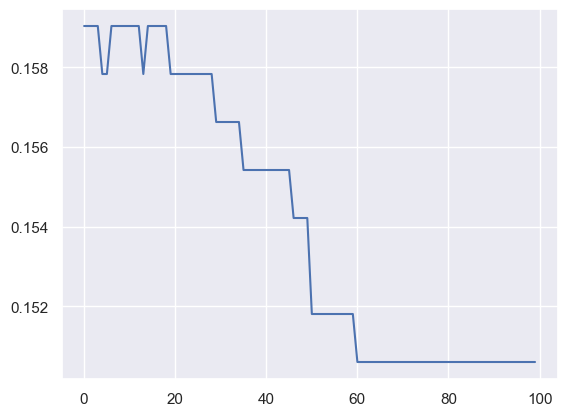

In [214]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

sns.lineplot(x = list(range(len(recall_val_list))), y = recall_val_list)
plt.show()

## Prepare Kaggle Submission    

In [5]:
order_sku_freq_df = df[["Order", "SKU"]].groupby(["Order", "SKU"]) \
                .size() \
                .reset_index(name='frequency') \
                .sort_values(by = ["Order", "frequency"], ascending = [True, False])


In [6]:
os_matrix = pd.pivot(order_sku_freq_df, index='Order', columns='SKU', values='frequency').fillna(0)

In [7]:
recc_df = pd.DataFrame()

for test_order in test_data["Order"].unique():
    test_order_df = test_data[test_data["Order"] == test_order]
    
    similar_order_df = pd.DataFrame()
    
    for _, row in test_order_df.iterrows():
        test_sku = row["SKU"]
        order_match = order_sku_freq_df[(order_sku_freq_df["SKU"] == test_sku) & (order_sku_freq_df["frequency"] == 1) ]
        similar_order_df = pd.concat([similar_order_df, order_match])
    
    similar_order_matrix = pd.pivot(similar_order_df, index='Order', columns='SKU', values='frequency').fillna(0)
    similar_order_matrix["row_sum"] = similar_order_matrix.sum(axis=1)
    similar_order_matrix = similar_order_matrix.sort_values("row_sum", ascending = False).reset_index()

    similarity_levels = list(similar_order_matrix["row_sum"].unique())
    similarity_levels.sort(reverse=True)

    similar_orders_lists = list()
    for similarity_level in similarity_levels:
        similar_orders_lists.append(list(similar_order_matrix[similar_order_matrix["row_sum"] == similarity_level]["Order"]))

    test_recc = pd.DataFrame()

    for similar_orders in similar_orders_lists:
        if len(similar_orders) > 30:
            probable_skus = df[df["Order"].isin(similar_orders)]["SKU"].value_counts().reset_index()
            test_recc = pd.concat([test_recc, probable_skus[~probable_skus["SKU"].isin(test_order_df["SKU"].unique())].iloc[:5]])
            test_recc = test_recc.drop_duplicates(subset = "SKU")
            if test_recc.shape[0] > 5:
                break

    test_recc = test_recc.iloc[:5].reset_index()

    test_recc["Order"] = test_order
    test_recc["Member"] = test_order_df["Member"].unique()[0]
    test_recc = test_recc[["Order", "SKU", "Member"]]

    recc_df = pd.concat([recc_df, test_recc], ignore_index = True)

In [8]:
recc_df = recc_df[["Order", "SKU", "Member"]].reset_index().rename(columns = {"index": "ID"})
recc_df["ID"] = recc_df["ID"].apply(lambda x: x+1)
recc_df.head()

,ID,Order,SKU,Member
0,1,7409204,15669864,SWLCNOE
1,2,7409204,15668467,SWLCNOE
2,3,7409204,15669878,SWLCNOE
3,4,7409204,15668465,SWLCNOE
4,5,7409204,15668451,SWLCNOE


In [9]:
recc_df.shape

(3190, 4)

In [10]:
recc_df.to_csv("order_similarity_based_recc.csv", index = False)

In [11]:
x = pd.read_csv("order_similarity_based_recc.csv")
x

,ID,Order,SKU,Member
0,1,7409204,15669864,SWLCNOE
1,2,7409204,15668467,SWLCNOE
2,3,7409204,15669878,SWLCNOE
3,4,7409204,15668465,SWLCNOE
4,5,7409204,15668451,SWLCNOE
...,...,...,...,...
3185,3186,7682167,15668381,SWOSHSO
3186,3187,7682167,15668688,SWOSHSO
3187,3188,7682167,15668460,SWOSHSO
3188,3189,7682167,15668465,SWOSHSO


In [12]:
len(set(x.Order))

638

# Recommendation Engine 7: Order Similarity using Jaccard 

In [5]:
df_train = pd.read_csv("df_train.csv")
df_train.head()

,Order,SKU,Member,Delivery Date,Name
0,8358896,15668375,SSCEHNS,2013-11-02,Root Vegetables
1,8358896,15668467,SSCEHNS,2013-11-02,Beans
2,8358896,15669863,SSCEHNS,2013-11-02,Moong Dal
3,8358896,15669778,SSCEHNS,2013-11-02,Other Dals
4,8358896,15669767,SSCEHNS,2013-11-02,Urad Dal


In [6]:
test_basket_df = pd.read_csv("test_basket_df.csv")

## Order-SKU Matrix

In [7]:
order_sku_freq_df = df_train[["Order", "SKU"]].groupby(["Order", "SKU"]) \
                .size() \
                .reset_index(name='frequency') \
                .sort_values(by = ["Order", "frequency"], ascending = [True, False])

order_sku_freq_df

,Order,SKU,frequency
0,7340368,7585571,1
1,7340368,7585573,1
2,7340368,15668379,1
3,7340368,15668381,1
4,7340368,15668460,1
...,...,...,...
27026,8387603,15668478,1
27027,8387603,15668520,1
27028,8387603,15668685,1
27029,8387603,15669790,1


In [8]:
os_matrix = pd.pivot(order_sku_freq_df, index='Order', columns='SKU', values='frequency').fillna(0)
os_matrix.head()

SKU,6884195,7541573,7543241,7547271,7547296,7547323,7548497,7548498,7548511,7548730,...,93141092,93141093,93156751,93174226,93176429,93176430,93176431,93289485,93289486,93289487
Order,,,,,,,,,,,,,,,,,,,,,
7340368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7340638,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7340893,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7341000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7341085,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Order Similarity Check

In [9]:
test_basket_df.head()

,Order,SKU,Member,Delivery Date,Name
0,8101324,15668684,SSCEHNS,2014-03-15,Beans
1,8101324,15668521,SSCEHNS,2014-03-15,Bread
2,8101324,15669811,SSCEHNS,2014-03-15,Almonds
3,8203855,15669873,SSCHNCE,2014-02-03,Whole Spices
4,8203855,15669767,SSCHNCE,2014-02-03,Urad Dal


In [10]:
test_order = 7374967
test_order_df = test_basket_df[test_basket_df["Order"] == test_order]
test_order_df

,Order,SKU,Member,Delivery Date,Name
620,7374967,15669760,SWHZENC,2013-09-24,Whole Spices
621,7374967,15668466,SWHZENC,2013-09-24,Root Vegetables
622,7374967,15669778,SWHZENC,2013-09-24,Other Dals
623,7374967,15668462,SWHZENC,2013-09-24,Gourd & Cucumber
624,7374967,15669866,SWHZENC,2013-09-24,Other Dals
625,7374967,15669869,SWHZENC,2013-09-24,Moong Dal
626,7374967,15668688,SWHZENC,2013-09-24,Root Vegetables
627,7374967,93174226,SWHZENC,2013-09-24,Body Wash


In [11]:
test_order_skus = set(test_order_df["SKU"])
print(test_order_skus)

{15669760, 15669866, 15669869, 15668462, 15668688, 15668466, 15669778, 93174226}


In [12]:
order = 7340368
past_order_skus = set(order_sku_freq_df[order_sku_freq_df["Order"] == order]["SKU"])
print(past_order_skus)

{15669856, 7585571, 7585573, 34985989, 15668460, 15668688, 15668468, 15668379, 15668381}


In [13]:
jaccard_similarity = len(test_order_skus.intersection(past_order_skus))/len(test_order_skus.union(past_order_skus))
jaccard_similarity

0.0625

In [14]:
test_order_skus = set(test_order_df["SKU"])

order_list = list()
similarity_list = list()

for order in list(order_sku_freq_df["Order"].unique()):
    past_order_skus = set(order_sku_freq_df[order_sku_freq_df["Order"] == order]["SKU"])
    order_list.append(order)
    similarity_list.append(len(test_order_skus.intersection(past_order_skus))/len(test_order_skus.union(past_order_skus)))

similar_orders_df = pd.DataFrame({"Order": order_list, "Similarity Score": similarity_list}).sort_values("Similarity Score", ascending = False)

similar_orders_df[similar_orders_df["Similarity Score"] > 0]

,Order,Similarity Score
842,7634822,0.454545
1978,8259451,0.285714
2120,8294914,0.250000
1458,7812321,0.250000
1356,7792047,0.250000
...,...,...
742,7593996,0.030303
1884,8216046,0.029412
2304,8351797,0.028571
318,7467133,0.027027


In [15]:
similar_orders_list = list(similar_orders_df[similar_orders_df["Similarity Score"] > 0]["Order"])
len(similar_orders_list)

1358

In [17]:
probable_skus = df_train[df_train["Order"].isin(similar_orders_list)]["SKU"].value_counts().reset_index()
test_recc = probable_skus[~probable_skus["SKU"].isin(test_order_df["SKU"].unique())]
test_recc.iloc[:5]

,SKU,count
4,15668381,288
5,15668460,282
6,15668379,267
7,15669878,251
9,15668467,211


In [10]:
%%time

recc_df = pd.DataFrame()

for test_order in test_basket_df["Order"].unique():
    test_order_df = test_basket_df[test_basket_df["Order"] == test_order]

    test_order_skus = set(test_order_df["SKU"])

    order_list = list()
    similarity_list = list()
    
    for order in list(order_sku_freq_df["Order"].unique()):
        past_order_skus = set(order_sku_freq_df[order_sku_freq_df["Order"] == order]["SKU"])
        order_list.append(order)
        similarity_list.append(len(test_order_skus.intersection(past_order_skus))/len(test_order_skus.union(past_order_skus)))
    
    similar_orders_df = pd.DataFrame({"Order": order_list, "Similarity Score": similarity_list}).sort_values("Similarity Score", ascending = False)
    similar_orders_df = similar_orders_df[similar_orders_df["Similarity Score"] > 0]

    similar_orders_list = list(similar_orders_df["Order"])

    probable_skus = df_train[df_train["Order"].isin(similar_orders_list)]["SKU"].value_counts().reset_index()
    test_recc = probable_skus[~probable_skus["SKU"].isin(test_order_df["SKU"].unique())]

    test_recc = test_recc.iloc[:5].reset_index()

    test_recc["Order"] = test_order
    test_recc["Member"] = test_order_df["Member"].unique()[0]
    test_recc = test_recc[["Order", "SKU", "Member"]]

    recc_df = pd.concat([recc_df, test_recc], ignore_index = True)

CPU times: user 26.1 s, sys: 66.9 ms, total: 26.2 s
Wall time: 26.2 s


In [12]:
recc_df

,Order,SKU,Member
0,8101324,15668460,SSCEHNS
1,8101324,15668381,SSCEHNS
2,8101324,15669780,SSCEHNS
3,8101324,15668379,SSCEHNS
4,8101324,15668688,SSCEHNS
...,...,...,...
825,7737427,15668688,SWRNESE
826,7737427,15668381,SWRNESE
827,7737427,15668460,SWRNESE
828,7737427,15668478,SWRNESE


## Evaluation using Recall@5 Metric

In [13]:
forgotten_items_df = pd.read_csv("forgotten_items_df.csv")
forgotten_items_df.head()

,Order,SKU,Member,Delivery Date,Name
0,8101324,15668377,SSCEHNS,2014-03-15,Root Vegetables
1,8101324,15669778,SSCEHNS,2014-03-15,Other Dals
2,8101324,15669814,SSCEHNS,2014-03-15,Jaggery
3,8101324,15669865,SSCEHNS,2014-03-15,Other Dals
4,8101324,15669970,SSCEHNS,2014-03-15,Cashews


In [14]:
recall_list = list()

for order in list(forgotten_items_df["Order"].unique()):
    forgotten_SKUs = forgotten_items_df[forgotten_items_df["Order"] == order]["SKU"]
    recc_SKUs = recc_df[recc_df["Order"] == order]["SKU"]
    recall = len(set(forgotten_SKUs).intersection(set(recc_SKUs)))/len(set(forgotten_SKUs))
    recall_list.append(recall)

In [15]:
np.mean(recall_list)

0.15903614457831325

In [16]:
def get_recall(i):
    recc_df = pd.DataFrame()
    
    for test_order in test_basket_df["Order"].unique():
        test_order_df = test_basket_df[test_basket_df["Order"] == test_order]
    
        test_order_skus = set(test_order_df["SKU"])
    
        order_list = list()
        similarity_list = list()
        
        for order in list(order_sku_freq_df["Order"].unique()):
            past_order_skus = set(order_sku_freq_df[order_sku_freq_df["Order"] == order]["SKU"])
            order_list.append(order)
            similarity_list.append(len(test_order_skus.intersection(past_order_skus))/len(test_order_skus.union(past_order_skus)))
        
        similar_orders_df = pd.DataFrame({"Order": order_list, "Similarity Score": similarity_list}).sort_values("Similarity Score", ascending = False)
        similar_orders_df = similar_orders_df[similar_orders_df["Similarity Score"] > i]
    
        similar_orders_list = list(similar_orders_df["Order"])
    
        probable_skus = df_train[df_train["Order"].isin(similar_orders_list)]["SKU"].value_counts().reset_index()
        test_recc = probable_skus[~probable_skus["SKU"].isin(test_order_df["SKU"].unique())]
    
        test_recc = test_recc.iloc[:5].reset_index()
    
        test_recc["Order"] = test_order
        test_recc["Member"] = test_order_df["Member"].unique()[0]
        test_recc = test_recc[["Order", "SKU", "Member"]]
    
        recc_df = pd.concat([recc_df, test_recc], ignore_index = True)
    
    forgotten_items_df = pd.read_csv("forgotten_items_df.csv")
    
    recall_list = list()
    
    for order in list(forgotten_items_df["Order"].unique()):
        forgotten_SKUs = forgotten_items_df[forgotten_items_df["Order"] == order]["SKU"]
        recc_SKUs = recc_df[recc_df["Order"] == order]["SKU"]
        recall = len(set(forgotten_SKUs).intersection(set(recc_SKUs)))/len(set(forgotten_SKUs))
        recall_list.append(recall)
    
    return np.mean(recall_list)

In [17]:
%%time

recall_val_list = list()
for i in [x/100 for x in range(0, 100, 5)]:
    try:
        recall_val_list.append(get_recall(i))
    except:
        break
    print(f"recall@5 for i = {i} is {get_recall(i)}")
print(np.mean(recall_val_list))

recall@5 for i = 0.0 is 0.15903614457831325
recall@5 for i = 0.05 is 0.16024096385542166
recall@5 for i = 0.1 is 0.19036144578313255
recall@5 for i = 0.15 is 0.2
recall@5 for i = 0.2 is 0.15180722891566267
recall@5 for i = 0.25 is 0.1144578313253012
recall@5 for i = 0.3 is 0.08313253012048193
recall@5 for i = 0.35 is 0.042168674698795185
recall@5 for i = 0.4 is 0.01927710843373494
recall@5 for i = 0.45 is 0.010843373493975903
recall@5 for i = 0.5 is 0.0
recall@5 for i = 0.55 is 0.0
recall@5 for i = 0.6 is 0.0
recall@5 for i = 0.65 is 0.0
recall@5 for i = 0.7 is 0.0
recall@5 for i = 0.75 is 0.0
recall@5 for i = 0.8 is 0.0
recall@5 for i = 0.85 is 0.0
recall@5 for i = 0.9 is 0.0
recall@5 for i = 0.95 is 0.0
0.05656626506024096
CPU times: user 17min 28s, sys: 3.4 s, total: 17min 31s
Wall time: 17min 33s


In [18]:
np.argmax(recall_val_list)

3

In [19]:
recall_val_list[np.argmax(recall_val_list)]

0.2

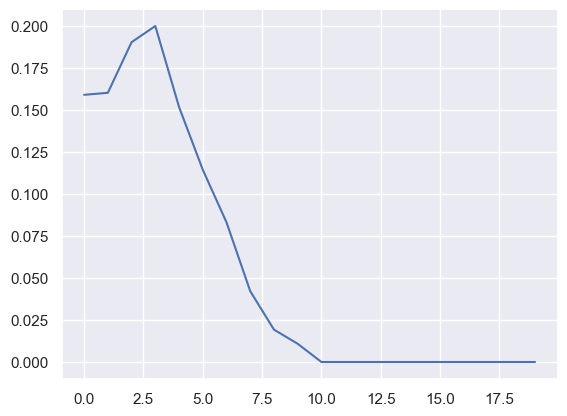

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

sns.lineplot(x = list(range(len(recall_val_list))), y = recall_val_list)
plt.show()

## Kaggle Submission

In [5]:
order_sku_freq_df = df[["Order", "SKU"]].groupby(["Order", "SKU"]) \
                .size() \
                .reset_index(name='frequency') \
                .sort_values(by = ["Order", "frequency"], ascending = [True, False])


In [6]:
os_matrix = pd.pivot(order_sku_freq_df, index='Order', columns='SKU', values='frequency').fillna(0)

In [7]:
%%time

recc_df = pd.DataFrame()

for test_order in test_data["Order"].unique():
    test_order_df = test_data[test_data["Order"] == test_order]

    test_order_skus = set(test_order_df["SKU"])

    order_list = list()
    similarity_list = list()
    
    for order in list(order_sku_freq_df["Order"].unique()):
        past_order_skus = set(order_sku_freq_df[order_sku_freq_df["Order"] == order]["SKU"])
        order_list.append(order)
        similarity_list.append(len(test_order_skus.intersection(past_order_skus))/len(test_order_skus.union(past_order_skus)))
    
    similar_orders_df = pd.DataFrame({"Order": order_list, "Similarity Score": similarity_list}).sort_values("Similarity Score", ascending = False)
    similar_orders_df = similar_orders_df[similar_orders_df["Similarity Score"] > 0.1]

    similar_orders_list = list(similar_orders_df["Order"])

    probable_skus = df[df["Order"].isin(similar_orders_list)]["SKU"].value_counts().reset_index()
    test_recc = probable_skus[~probable_skus["SKU"].isin(test_order_df["SKU"].unique())]

    test_recc = test_recc.iloc[:5].reset_index()

    test_recc["Order"] = test_order
    test_recc["Member"] = test_order_df["Member"].unique()[0]
    test_recc = test_recc[["Order", "SKU", "Member"]]

    recc_df = pd.concat([recc_df, test_recc], ignore_index = True)

CPU times: user 1min 46s, sys: 349 ms, total: 1min 47s
Wall time: 1min 47s


In [8]:
recc_df["Order"].value_counts()

Order
7409204    5
8250969    5
7727449    5
8285456    5
7517068    5
          ..
8077922    5
7682148    5
8374672    5
8065270    5
7682167    5
Name: count, Length: 638, dtype: int64

In [9]:
recc_df = recc_df[["Order", "SKU", "Member"]].reset_index().rename(columns = {"index": "ID"})
recc_df["ID"] = recc_df["ID"].apply(lambda x: x+1)
recc_df.head()

,ID,Order,SKU,Member
0,1,7409204,15668381,SWLCNOE
1,2,7409204,15668460,SWLCNOE
2,3,7409204,15668465,SWLCNOE
3,4,7409204,15668468,SWLCNOE
4,5,7409204,15668467,SWLCNOE


In [10]:
recc_df.shape

(3190, 4)

In [11]:
recc_df.to_csv("order_similarity_based_recc2.csv", index = False)